In [5]:
# prompt: truy cập google drive

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import csv
import matplotlib.pyplot as plt
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import FeatureUnion
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import KFold
from statistics import mean
import joblib



import os
for dirname, _, filenames in os.walk('/content/drive/MyDrive/dataset/Cycling_data/Raw_data'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/content/drive/MyDrive/dataset/Cycling_data/Raw_data/Active 2024_11_27_10_4_25.txt


In [3]:
from pathlib import Path
work_dir = Path('/content/drive/MyDrive/dataset/Cycling_data')

In [ ]:
try:
    os.mkdir(work_dir/'figures')
    os.mkdir(work_dir/'models')
    os.mkdir(work_dir/'saved_objects')
except:
    print("Already have directory!")

Already have directory!


### **Chuyển data sang csv**

`Bởi vì file có định dạng thô, khó xử lý dữ liệu nên cần thông qua bước tổng hợp dữ liệu sang file csv để tiện cho các thao tác dữ liệu!`







In [ ]:
# prompt: xóa file /content/drive/MyDrive/dataset/Cycling_data/cycling.csv

!rm /content/drive/MyDrive/dataset/Cycling_data/cycling.csv


In [ ]:
fields = ['date','t','Tau_Motor','Tau_1', 'Tau_2', 'vel', 'encoder_count', 'mode', 'level', 'turn']
outputfile = work_dir/"cycling.csv"
with open(outputfile, 'w') as csvfile:
    writer = csv.DictWriter(csvfile, fieldnames=fields)
    writer.writeheader()

def updateLog(date,t,Tau_Motor,Tau_1,Tau_2,vel,encoder_count,mode,level, turn):
    list_append = [{'date':'{}'.format(date),'t':'{:.03f}'.format(t),'Tau_Motor':'{:.02f}'.format(Tau_Motor),
                    'Tau_1': '{:.02f}'.format(Tau_1), 'Tau_2': '{:.02f}'.format(Tau_2), 'vel': '{:.02f}'.format(vel),
                    'encoder_count': '{:.02f}'.format(encoder_count), 'mode': '{}'.format(mode), 'level': '{}'.format(level), 'turn': '{}'.format(turn)}]
    with open(outputfile, 'a') as csvfile:
        writer = csv.DictWriter(csvfile, fieldnames=fields)
        writer.writerows(list_append)
        csvfile.close()

In [ ]:
turn  = 0
for dirname, _, filenames in os.walk(work_dir/'Raw_data/'):
    for filename in filenames:
        file_path = os.path.join(dirname, filename)
        print(file_path)
        filename = filename.replace(".txt", "")
        name = filename.split(" ")
        name = name[1]
        strDate = name.split("_")
        print(strDate)
        with open(file_path, "r") as file:
            l = []
            for line in file:
                line = line.strip()
                if line[0].isdigit():
                    l.append(line.split("\t"))
                else:
                    mode = line.split(";")
                    print("Catch!")
                    # print(l)
                    print(mode)
                    turn+=1
                    date = "{}:{}:{} - {}/{}/{}".format(strDate[3], strDate[4], strDate[5], strDate[2], strDate[1], strDate[0])
                    for i in l:
                        updateLog(date, float(i[0]), float(i[1]), float(i[2]), float(i[3]), float(i[4]), float(i[5]), mode[0], mode[1][-1], turn)
                    l = []

/content/drive/MyDrive/dataset/Cycling_data/Raw_data/Active 2024_11_27_10_4_25.txt
['2024', '11', '27', '10', '4', '25']
Catch!
['Active', ' Level 1']
Catch!
['Active', ' Level 2']
Catch!
['Active', ' Level 3']
Catch!
['Active', ' Level 4']
Catch!
['Active', ' Level 5']
Catch!
['Active', ' Level 4']
Catch!
['Active', ' Level 3']
Catch!
['Active', ' Level 2']
Catch!
['Active', ' Level 1']
Catch!
['Active', ' Level 0']
Catch!
['Active', ' Level 1']
Catch!
['Active', ' Level 0']
Catch!
['Active', ' Level 5']
Catch!
['Active', ' Level 3']
Catch!
['Active', ' Level 2']
Catch!
['Active', ' Level 1']
Catch!
['Active', ' Level 0']


In [6]:
# LOAD DATA
raw_data = pd.read_csv(r'/content/drive/MyDrive/dataset/Cycling_data/cyclingLabel.csv')

### Config label

In [ ]:
# Fill NaN values in 'period' column with the previous valid value
previous_period = None
previous_push_leg = None
for index, row in raw_data.iterrows():
    if pd.notna(row['period']):
        previous_period = row['period']
        previous_push_leg = row['push_leg']
    else:
        raw_data.loc[index, 'period'] = previous_period
        raw_data.loc[index, 'push_leg'] = previous_push_leg
# Apply the absolute value function to the specified columns.
raw_data[['Tau_1', 'Tau_2']] = raw_data[['Tau_1', 'Tau_2']].abs()

raw_data.to_csv(work_dir / 'cyclingLabel.csv', index=False)

In [7]:
# prompt: từ raw_data, theo từng period, lấy (max encoder - min encoder) ra số xung encoder, phiên từng hàng từ xung encoder sang số độ (0-360) lưu vào cột 'degree'

# Assuming 'raw_data' DataFrame is already loaded as in your provided code.
# Also assuming 'encoder_count' column exists and represents encoder readings.

def calculate_degree(row):
    # Calculate the difference between max and min encoder counts within each period.
    period_data = raw_data[raw_data['period'] == row['period']]
    encoder_diff = period_data['encoder_count'].max() - period_data['encoder_count'].min()

    # Assuming a linear relationship between encoder pulses and degrees (0-360).
    # Adjust the scaling factor if necessary based on your encoder setup.
    scaling_factor = 360 / encoder_diff  # Example scaling factor

    # Calculate degree for the current row.
    degree = (row['encoder_count'] - period_data['encoder_count'].min()) * scaling_factor

    return degree

# Apply the function to create the 'degree' column.
raw_data['degree'] = raw_data.apply(calculate_degree, axis=1)

# Print or save the updated DataFrame
raw_data

,date,t,Tau_Motor,Tau_1,Tau_2,vel,encoder_count,mode,level,turn,period,push_leg,degree
0,10:4:25 - 27/11/2024,4.628,3.45,28.72,14.45,7.88,156,Active,1,11,46,R,0.000000
1,10:4:25 - 27/11/2024,4.748,3.45,28.70,14.60,11.84,218,Active,1,11,46,R,9.683297
2,10:4:25 - 27/11/2024,4.962,3.62,28.63,14.79,16.32,355,Active,1,11,46,R,31.080260
3,10:4:25 - 27/11/2024,5.011,3.60,28.63,14.79,16.32,385,Active,1,11,46,R,35.765727
4,10:4:25 - 27/11/2024,5.075,3.60,28.55,15.38,14.94,421,Active,1,11,46,R,41.388286
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1131,10:4:25 - 27/11/2024,128.197,4.45,29.30,12.84,17.83,107706,Active,4,16,90,L,313.754325
1132,10:4:25 - 27/11/2024,128.290,5.36,29.29,13.12,17.83,107772,Active,4,16,90,L,324.031142
1133,10:4:25 - 27/11/2024,128.404,5.49,29.26,13.29,17.89,107854,Active,4,16,90,L,336.799308
1134,10:4:25 - 27/11/2024,128.488,5.49,29.24,13.43,17.92,107915,Active,4,16,90,L,346.297578


In [8]:
import pandas as pd
import numpy as np

def assign_phase(group):
    # Sort the group by encoder_count to ensure correct phase assignment
    group = group.sort_values('encoder_count')
    last_sample_degree = group['degree'].iloc[-1]

    group['phase'] = 0  # Initialize the phase column

    for index, row in group.iterrows():
        degree_diff = abs(row['degree'] - last_sample_degree)
        if degree_diff < 30:
            group.loc[index, 'phase'] = 4
        elif 30 <= degree_diff < 180:
            group.loc[index, 'phase'] = 3
        elif 180 <= degree_diff < 210:
            group.loc[index, 'phase'] = 2
        else:  # 210 <= degree_diff <= 360
            group.loc[index, 'phase'] = 1

    return group

# Group data by 'period' and apply the function
raw_data = raw_data.groupby('period', group_keys=True).apply(assign_phase)

# Reset the index to remove the multi-index created by the groupby operation
raw_data = raw_data.reset_index(drop=True)

# Print or save the updated DataFrame
raw_data


<ipython-input-8-0ab31ff74c50>:25: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  raw_data = raw_data.groupby('period', group_keys=True).apply(assign_phase)


,date,t,Tau_Motor,Tau_1,Tau_2,vel,encoder_count,mode,level,turn,period,push_leg,degree,phase
0,10:4:25 - 27/11/2024,4.628,3.45,28.72,14.45,7.88,156,Active,1,11,46,R,0.000000,1
1,10:4:25 - 27/11/2024,4.748,3.45,28.70,14.60,11.84,218,Active,1,11,46,R,9.683297,1
2,10:4:25 - 27/11/2024,4.962,3.62,28.63,14.79,16.32,355,Active,1,11,46,R,31.080260,1
3,10:4:25 - 27/11/2024,5.011,3.60,28.63,14.79,16.32,385,Active,1,11,46,R,35.765727,1
4,10:4:25 - 27/11/2024,5.075,3.60,28.55,15.38,14.94,421,Active,1,11,46,R,41.388286,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1131,10:4:25 - 27/11/2024,128.197,4.45,29.30,12.84,17.83,107706,Active,4,16,90,L,313.754325,3
1132,10:4:25 - 27/11/2024,128.290,5.36,29.29,13.12,17.83,107772,Active,4,16,90,L,324.031142,3
1133,10:4:25 - 27/11/2024,128.404,5.49,29.26,13.29,17.89,107854,Active,4,16,90,L,336.799308,4
1134,10:4:25 - 27/11/2024,128.488,5.49,29.24,13.43,17.92,107915,Active,4,16,90,L,346.297578,4


In [9]:
# prompt: # Derivaive
# if view_col == 'vel':
#     derivative = savgol_filter(filtered_data, window_length=3, polyorder=2, deriv=1)
# elif (view_col == 'Tau_1') or (view_col == 'Tau_2'):
#     derivative = savgol_filter(filtered_data, window_length=5, polyorder=3, deriv=1)
# else:
#     derivative = savgol_filter(filtered_data, window_length=5, polyorder=2, deriv=1)
# Từ raw_data, thêm các cột đạo hàm của tau motor,  tau 1,tau 2, vel

from scipy.signal import savgol_filter

# Assuming 'raw_data' DataFrame is already loaded and processed as in your provided code.

def add_derivatives(df):
    for col in ['Tau_Motor', 'Tau_1', 'Tau_2', 'vel']:
        # Apply Savitzky-Golay filter for derivative calculation
        if col == 'vel':
            derivative = savgol_filter(df[col], window_length=3, polyorder=2, deriv=1)
        elif col in ('Tau_1', 'Tau_2'):
            derivative = savgol_filter(df[col], window_length=5, polyorder=3, deriv=1)
        else:
            derivative = savgol_filter(df[col], window_length=5, polyorder=2, deriv=1)

        df[f'{col}_deriv'] = derivative  # Add the derivative column to the DataFrame
    return df

raw_data = add_derivatives(raw_data)
print(raw_data.head())

                   date      t  Tau_Motor  Tau_1  Tau_2    vel  encoder_count  \
0  10:4:25 - 27/11/2024  4.628       3.45  28.72  14.45   7.88            156   
1  10:4:25 - 27/11/2024  4.748       3.45  28.70  14.60  11.84            218   
2  10:4:25 - 27/11/2024  4.962       3.62  28.63  14.79  16.32            355   
3  10:4:25 - 27/11/2024  5.011       3.60  28.63  14.79  16.32            385   
4  10:4:25 - 27/11/2024  5.075       3.60  28.55  15.38  14.94            421   

     mode  level  turn  period push_leg     degree  phase  Tau_Motor_deriv  \
0  Active      1    11      46        R   0.000000      1         0.099286   
1  Active      1    11      46        R   9.683297      1         0.072143   
2  Active      1    11      46        R  31.080260      1         0.045000   
3  Active      1    11      46        R  35.765727      1         0.028000   
4  Active      1    11      46        R  41.388286      1        -0.004000   

   Tau_1_deriv  Tau_2_deriv  vel_deriv  
0  

In [10]:
raw_data.to_csv(work_dir / 'cyclingLabel.csv', index=False)

# **1.   Preview data**

In [11]:
# DISCOVER THE DATA TO GAIN INSIGHTS

# Quick view of the data
print('\n____________ Dataset info ____________')
print(raw_data.info())
print('\n____________ Some first data examples ____________')
print(raw_data.head(3))
print('\n____________ Statistics of numeric features ____________')
print(raw_data.describe())


____________ Dataset info ____________
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1136 entries, 0 to 1135
Data columns (total 18 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   date             1136 non-null   object 
 1   t                1136 non-null   float64
 2   Tau_Motor        1136 non-null   float64
 3   Tau_1            1136 non-null   float64
 4   Tau_2            1136 non-null   float64
 5   vel              1136 non-null   float64
 6   encoder_count    1136 non-null   int64  
 7   mode             1136 non-null   object 
 8   level            1136 non-null   int64  
 9   turn             1136 non-null   int64  
 10  period           1136 non-null   int64  
 11  push_leg         1136 non-null   object 
 12  degree           1136 non-null   float64
 13  phase            1136 non-null   int64  
 14  Tau_Motor_deriv  1136 non-null   float64
 15  Tau_1_deriv      1136 non-null   float64
 16  Tau_2_deriv      113

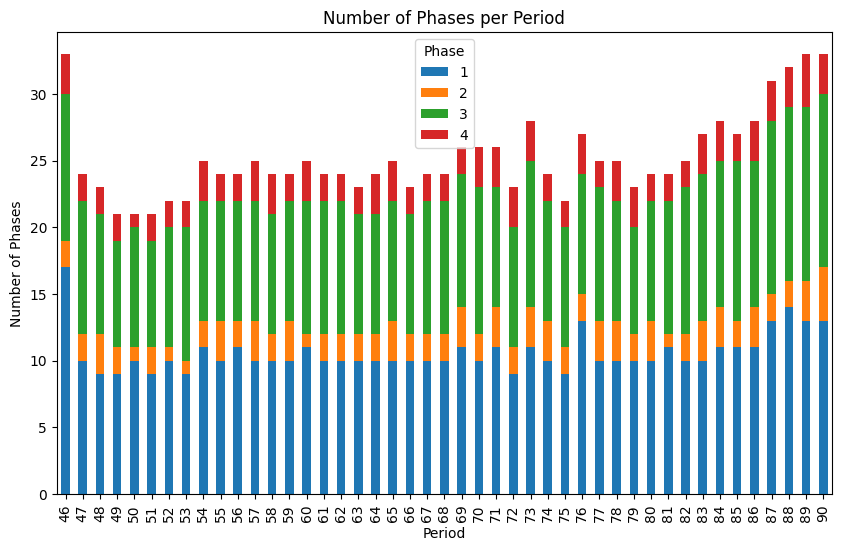

In [12]:
# prompt: từ raw data, vẽ biểu đồ số phase trên period

import matplotlib.pyplot as plt

# Group data by 'period' and count the occurrences of each phase
phase_counts = raw_data.groupby('period')['phase'].value_counts().unstack()

# Plot the number of phases per period
phase_counts.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.xlabel('Period')
plt.ylabel('Number of Phases')
plt.title('Number of Phases per Period')
plt.legend(title='Phase')
plt.show()

Max difference: 2409
Min difference: 2117
Mean difference: 2308.9555555555557

Periods with max-min difference less than 1400:
[]


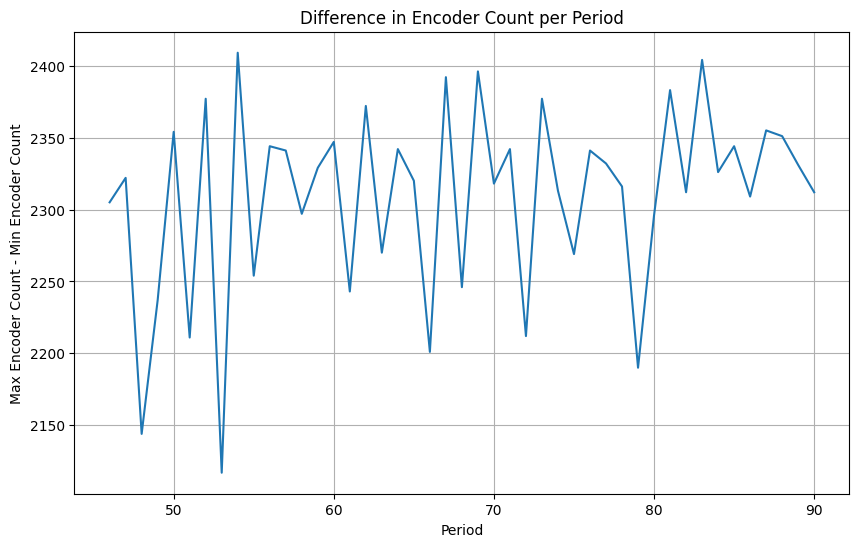

In [13]:
# prompt: từ raw_data, trên mỗi nhóm hàng có cùng 'period', lấy max encoder_count - min encode_count.
# vẽ biểu đồ mới với data trên, tính max, min và mean của data trên
# Tìm data period có max-min thấp hơn 1400

import matplotlib.pyplot as plt

# Group data by 'period' and calculate the difference between max and min 'encoder_count'
period_diff = raw_data.groupby('period')['encoder_count'].agg(['max', 'min'])
period_diff['diff'] = period_diff['max'] - period_diff['min']

# Create the new plot
plt.figure(figsize=(10, 6))
plt.plot(period_diff.index, period_diff['diff'])
plt.xlabel('Period')
plt.ylabel('Max Encoder Count - Min Encoder Count')
plt.title('Difference in Encoder Count per Period')
plt.grid(True)

# Calculate and print max, min, and mean of the differences
max_diff = period_diff['diff'].max()
min_diff = period_diff['diff'].min()
mean_diff = period_diff['diff'].mean()
print(f"Max difference: {max_diff}")
print(f"Min difference: {min_diff}")
print(f"Mean difference: {mean_diff}")

# Find periods with max-min difference less than 1400
low_diff_periods = period_diff[period_diff['diff'] < 1400].index.tolist()
print("\nPeriods with max-min difference less than 1400:")
print(low_diff_periods)

plt.show()

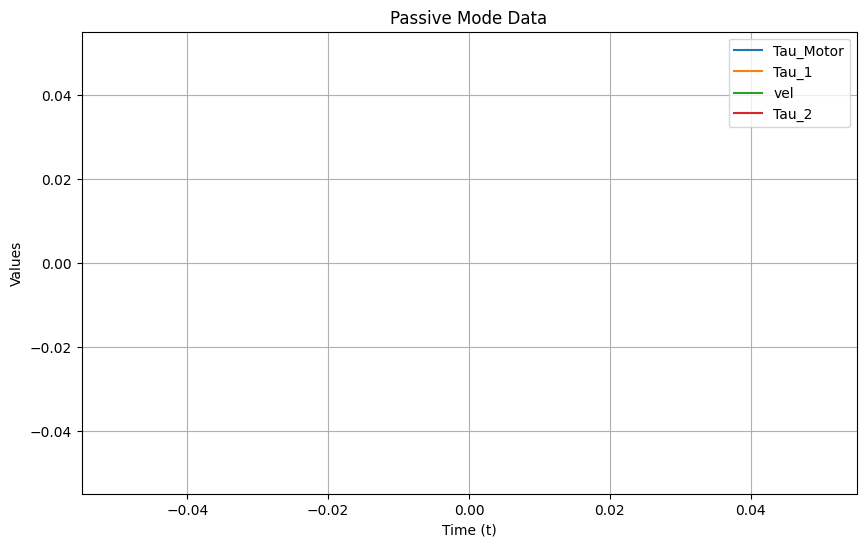

In [ ]:
# prompt: Generate column ['Tau_Motor', 'Tau_1', 'vel', 'Tau_2'] of raw_data['mode'] = Passive in a diagram with x-axis is column "t"

import matplotlib.pyplot as plt

# Filter data for 'mode' == 'Passive'
passive_data = raw_data[raw_data['mode'] == 'Passive']

# Create the plot
plt.figure(figsize=(10, 6))

plt.plot(passive_data['t'], passive_data['Tau_Motor'], label='Tau_Motor')
plt.plot(passive_data['t'], passive_data['Tau_1'], label='Tau_1')
plt.plot(passive_data['t'], passive_data['vel'], label='vel')
plt.plot(passive_data['t'], passive_data['Tau_2'], label='Tau_2')

# Customize the plot
plt.xlabel('Time (t)')
plt.ylabel('Values')
plt.title('Passive Mode Data')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

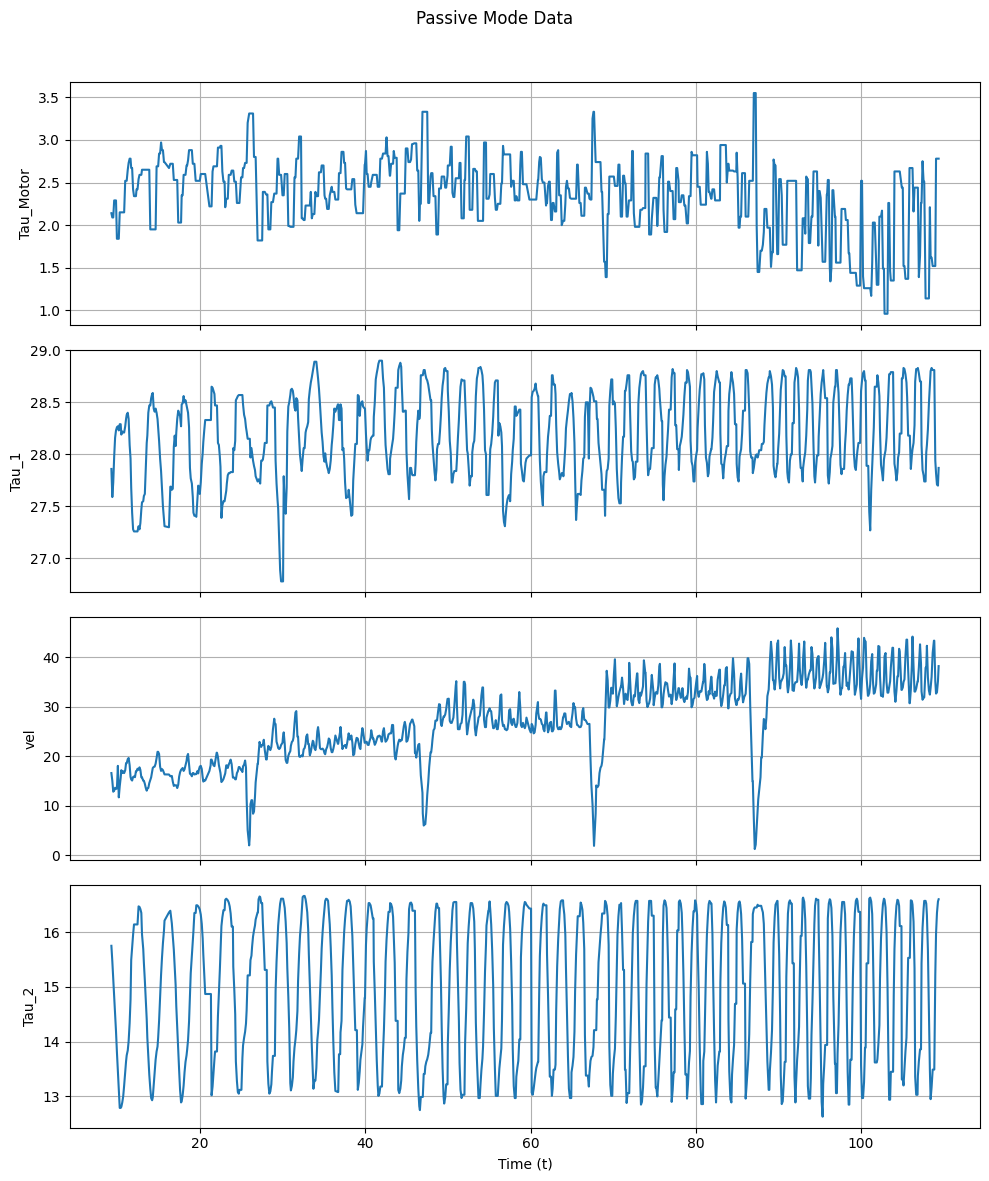

In [ ]:
# prompt: Generate column ['Tau_Motor', 'Tau_1', 'vel', 'Tau_2'] of raw_data['mode'] = Passive in 4 diagram with x-axis is column "t"

# Assuming raw_data and passive_data are already defined as in the provided code.

import matplotlib.pyplot as plt

#Create the plot with 4 subplots
fig, axes = plt.subplots(4, 1, figsize=(10, 12), sharex=True) # sharex ensures the x-axis is the same for all plots

#Plot each column in a separate subplot
axes[0].plot(passive_data['t'], passive_data['Tau_Motor'])
axes[0].set_ylabel('Tau_Motor')
axes[0].grid(True)

axes[1].plot(passive_data['t'], passive_data['Tau_1'])
axes[1].set_ylabel('Tau_1')
axes[1].grid(True)

axes[2].plot(passive_data['t'], passive_data['vel'])
axes[2].set_ylabel('vel')
axes[2].grid(True)

axes[3].plot(passive_data['t'], passive_data['Tau_2'])
axes[3].set_ylabel('Tau_2')
axes[3].set_xlabel('Time (t)') #x-axis label only on the bottom plot
axes[3].grid(True)


plt.suptitle('Passive Mode Data') # overall title for the subplots
plt.tight_layout(rect=[0, 0, 1, 0.96]) # Adjust layout to prevent overlapping
plt.show()

# Lấy 1 period quan sát

In [ ]:
period = 50

view_data = raw_data[raw_data["period"] == period]
# view_data = raw_data[(raw_data["period"] == period) | (raw_data["period"] == period+1)]
# Quick view of the data
print('\n____________ Some first data examples ____________')
print(view_data.head(3))
print('\n____________ Some last data examples ____________')
print(view_data.tail(3))
print('\n____________ Statistics of numeric features ____________')
print(view_data.describe())

# # Specify the path and name of the file
# file_path = work_dir/"figures/turn {0}/turn_{0}_{1}_Level_{2}.txt".format(turn,view_data['mode'].iloc[0],view_data['level'].iloc[0])
# print(file_path)
# # Open the file in write mode and write the text
# with open(file_path, "w") as file:
#     file.write("turn {}, mode {}, level {}.".format(turn,view_data['mode'].iloc[0],view_data['level'].iloc[0]))



____________ Some first data examples ____________
                     date       t  Tau_Motor  Tau_1  Tau_2    vel  \
101  10:4:25 - 27/11/2024  15.664       3.48  28.84  13.21  31.89   
102  10:4:25 - 27/11/2024  15.781       3.48  28.74  13.81  29.67   
103  10:4:25 - 27/11/2024  15.941       3.47  28.74  13.81  25.24   

     encoder_count    mode  level  turn  period push_leg     degree  
101           9800  Active      1    11      50        R   0.000000  
102           9930  Active      1    11      50        R  19.881054  
103          10078  Active      1    11      50        R  42.514868  

____________ Some last data examples ____________
                     date       t  Tau_Motor  Tau_1  Tau_2    vel  \
119  10:4:25 - 27/11/2024  17.643       3.50  29.12  12.76  26.48   
120  10:4:25 - 27/11/2024  17.735       3.51  29.14  12.88  28.38   
121  10:4:25 - 27/11/2024  17.931       3.51  29.14  13.07  31.61   

     encoder_count    mode  level  turn  period push_leg      d

# **1.1. Statistic**




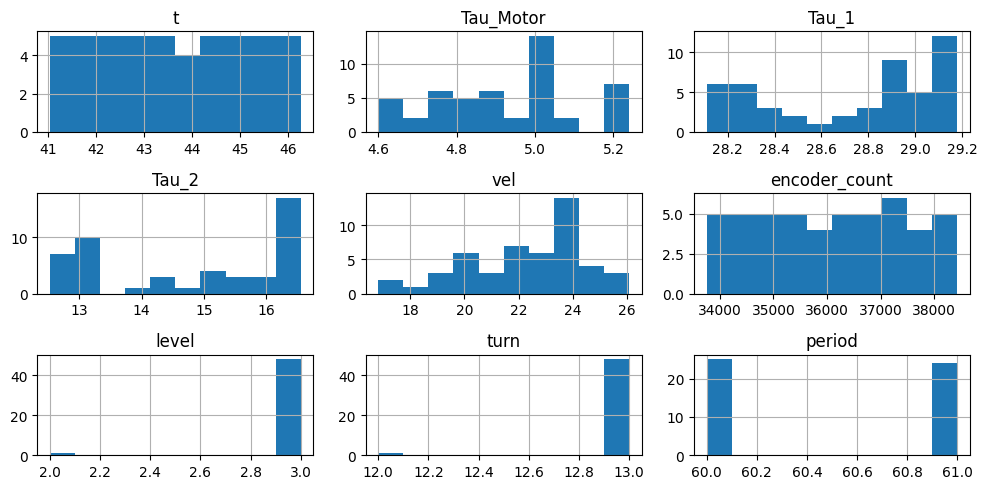

In [ ]:
view_data.hist(figsize=(10,5)) #bins: no. of intervals
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
plt.tight_layout()
# plt.savefig(work_dir/'figures/turn {}/hist_raw_data.png'.format(turn), format='png', dpi=300) # must save before show()
# plt.show()

In [ ]:
def moving_average(x, w):
    """
    Average filter for reduce noise

    Args:
        x: Input array
        w: window size

    Returns:
        Filter array
    """
    return np.convolve(x, np.ones(w), 'same') / w

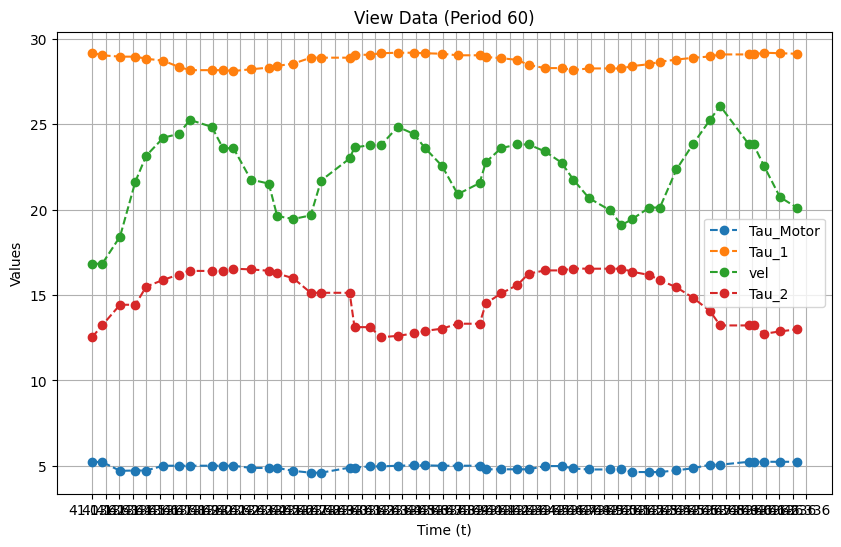

In [ ]:
# prompt: viết code vẽ view_data dạng điểm, nối các điểm bằng đường dứt
# Chỉnh đơn vị chia trục hoành nhỏ hơn step data

import matplotlib.pyplot as plt

# Assuming view_data is already defined as in the provided code.

plt.figure(figsize=(10, 6))

# Plot the data as points connected by dashed lines
plt.plot(view_data['t'], view_data['Tau_Motor'], marker='o', linestyle='--', label='Tau_Motor')
plt.plot(view_data['t'], view_data['Tau_1'], marker='o', linestyle='--', label='Tau_1')
plt.plot(view_data['t'], view_data['vel'], marker='o', linestyle='--', label='vel')
plt.plot(view_data['t'], view_data['Tau_2'], marker='o', linestyle='--', label='Tau_2')

# Customize the plot
plt.xlabel('Time (t)')
plt.ylabel('Values')
plt.title('View Data (Period {})'.format(period))
plt.legend()
plt.grid(True)

# Adjust x-axis ticks for smaller steps
# Example: Set ticks every 0.1 units (adjust as needed)
plt.xticks(np.arange(min(view_data['t']), max(view_data['t']) + 0.1, 0.1))

# Show the plot
plt.show()

## Tổng quan data

In [ ]:
view_data

,date,t,Tau_Motor,Tau_1,Tau_2,vel,encoder_count,mode,level,turn,period,push_leg,degree
101,10:4:25 - 27/11/2024,15.664,3.48,28.84,13.21,31.89,9800,Active,1,11,50,R,0.000000
102,10:4:25 - 27/11/2024,15.781,3.48,28.74,13.81,29.67,9930,Active,1,11,50,R,19.881054
103,10:4:25 - 27/11/2024,15.941,3.47,28.74,13.81,25.24,10078,Active,1,11,50,R,42.514868
104,10:4:25 - 27/11/2024,16.023,3.47,28.74,13.81,22.47,10152,Active,1,11,50,R,53.831776
105,10:4:25 - 27/11/2024,16.105,3.47,28.43,15.68,22.56,10225,Active,1,11,50,R,64.995752
106,10:4:25 - 27/11/2024,16.233,3.45,28.31,16.01,22.78,10344,Active,1,11,50,R,83.194562
107,10:4:25 - 27/11/2024,16.308,3.45,28.20,16.26,22.78,10418,Active,1,11,50,R,94.511470
108,10:4:25 - 27/11/2024,16.427,3.45,28.15,16.46,25.04,10545,Active,1,11,50,R,113.933730
109,10:4:25 - 27/11/2024,16.561,3.45,28.16,16.55,26.89,10688,Active,1,11,50,R,135.802889
110,10:4:25 - 27/11/2024,16.631,3.45,28.22,16.55,26.44,10762,Active,1,11,50,R,147.119796


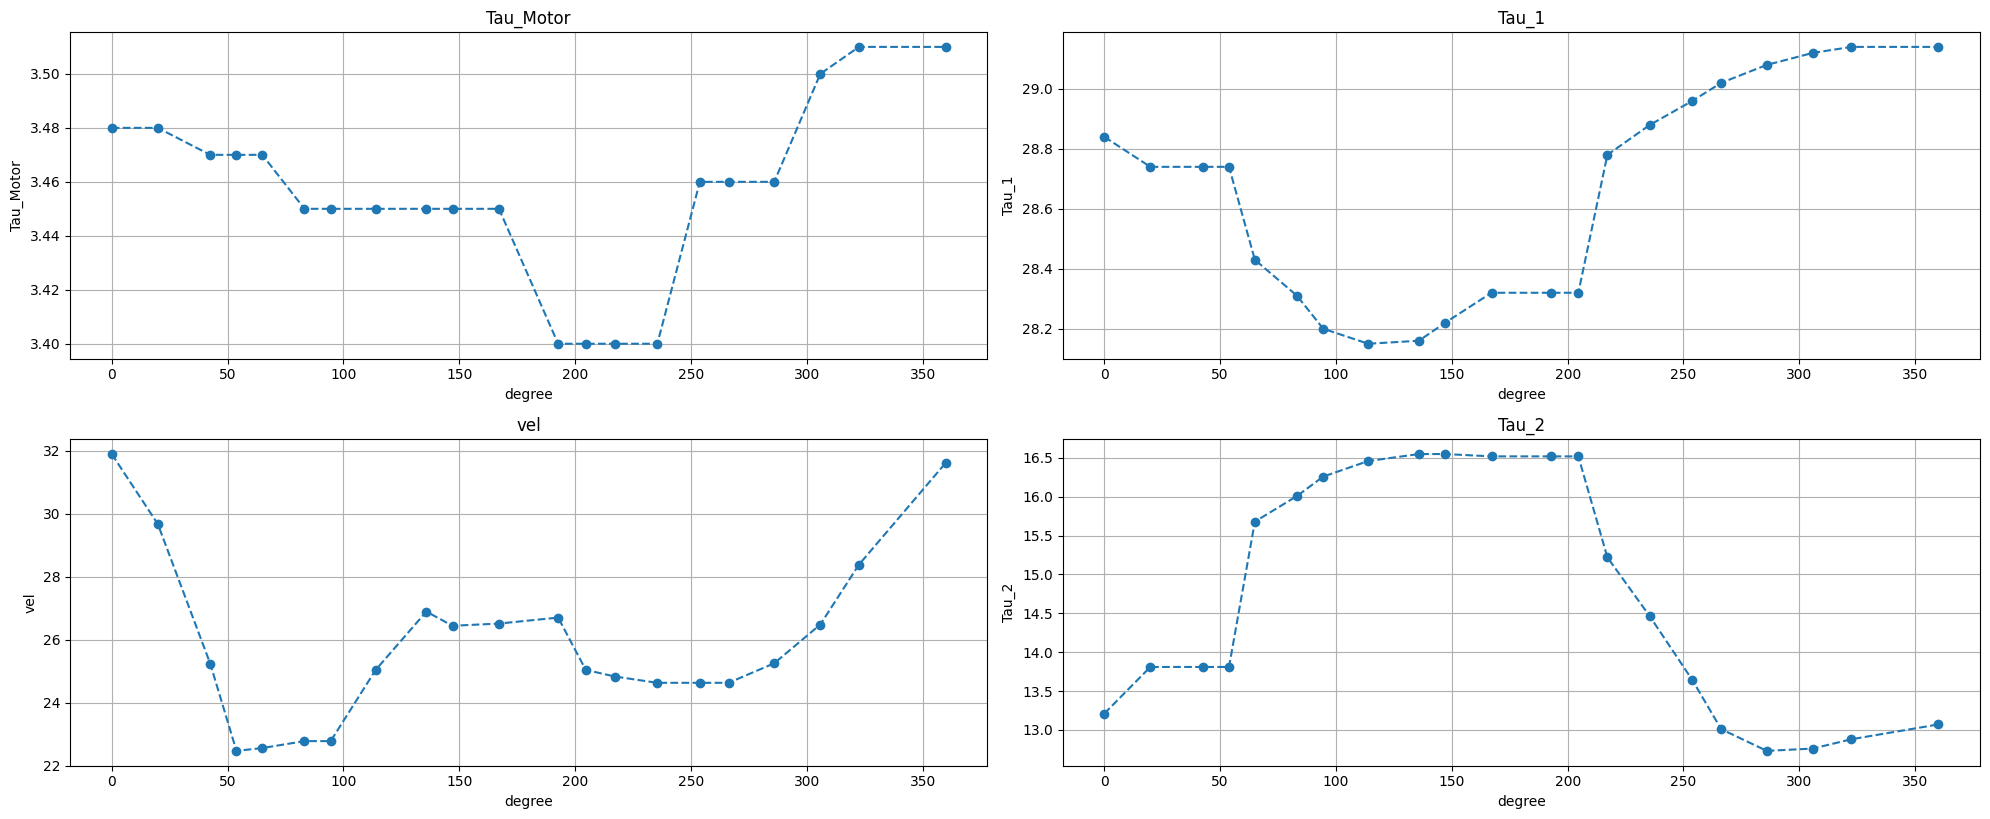

In [ ]:
columns_to_plot = ['Tau_Motor', 'Tau_1', 'vel', 'Tau_2']

# Create a plot for each specified column with 't' as the x-axis
plt.figure(figsize=(20, 16))  # Adjust the figure size as needed

for i, col in enumerate(columns_to_plot, start=1):
    plt.subplot(4, 2, i)  # Creates a 4x2 grid for subplots, adjust if you have a different number of columns
    plt.plot(view_data['degree'], view_data[col], label=col, marker='o', linestyle='--')
    plt.xlabel('degree')
    plt.ylabel(col)
    plt.title(f'{col}')
    plt.grid(True)
plt.tight_layout()  # Adjust layout to avoid overlapping plots
# plt.savefig(work_dir/'figures/turn {}/view_data.png'.format(turn), format='png', dpi=300) # must save before show()
plt.show()

# Vẽ biểu đồ so sánh

In [ ]:
try:
    os.mkdir(work_dir/'figures/view_data_diagram')
except:
    print("Already have directory!")

In [ ]:
# prompt: columns_to_plot = ['Tau_Motor', 'Tau_1', 'vel', 'Tau_2']
# # Create a plot for each specified column with 't' as the x-axis
# plt.figure(figsize=(20, 16))  # Adjust the figure size as needed
# for i, col in enumerate(columns_to_plot, start=1):
#     plt.subplot(4, 2, i)  # Creates a 4x2 grid for subplots, adjust if you have a different number of columns
#     plt.plot(view_data['encoder_count'], view_data[col], label=col, marker='o', linestyle='--')
#     plt.xlabel('encoder_count')
#     plt.ylabel(col)
#     plt.title(f'{col}')
#     plt.grid(True)
# plt.tight_layout()  # Adjust layout to avoid overlapping plots
# # plt.savefig(work_dir/'figures/turn {}/view_data.png'.format(turn), format='png', dpi=300) # must save before show()
# plt.show()
# Tạo loop vẽ diagram tất cả các period

# Assuming raw_data is already loaded and processed as in the provided code.

for period in raw_data['period'].unique():
    # Filter data for the current period
    print('period: ',period)
    view_data = raw_data[raw_data["period"] == period]
    columns_to_plot = ['Tau_Motor', 'Tau_1', 'vel', 'Tau_2']

    plt.figure(figsize=(20, 16))
    for i, col in enumerate(columns_to_plot, start=1):
        print(col)
        plt.subplot(4, 2, i)
        plt.plot(view_data['encoder_count'], view_data[col], label=col, marker='o', linestyle='--')
        plt.xlabel('encoder_count')
        plt.ylabel(col)
        plt.title(f'{col} - Period {period}')
        plt.grid(True)
    plt.tight_layout()
    print("Save file!")
    plt.savefig(work_dir / 'figures/view_data_diagram/view_data_{}.png'.format(period), format='png', dpi=300)
    plt.close() # Close the plot to free memory
print("Finish!")

period:  1.0
Tau_Motor
Tau_1
vel
Tau_2
Save file!
period:  2.0
Tau_Motor
Tau_1
vel
Tau_2
Save file!
period:  3.0
Tau_Motor
Tau_1
vel
Tau_2
Save file!
period:  4.0
Tau_Motor
Tau_1
vel
Tau_2
Save file!
period:  5.0
Tau_Motor
Tau_1
vel
Tau_2
Save file!
period:  6.0
Tau_Motor
Tau_1
vel
Tau_2
Save file!
period:  7.0
Tau_Motor
Tau_1
vel
Tau_2
Save file!
period:  8.0
Tau_Motor
Tau_1
vel
Tau_2
Save file!
period:  9.0
Tau_Motor
Tau_1
vel
Tau_2
Save file!
period:  10.0
Tau_Motor
Tau_1
vel
Tau_2
Save file!
period:  11.0
Tau_Motor
Tau_1
vel
Tau_2
Save file!
period:  12.0
Tau_Motor
Tau_1
vel
Tau_2
Save file!
period:  13.0
Tau_Motor
Tau_1
vel
Tau_2
Save file!
period:  14.0
Tau_Motor
Tau_1
vel
Tau_2
Save file!
period:  15.0
Tau_Motor
Tau_1
vel
Tau_2
Save file!
period:  16.0
Tau_Motor
Tau_1
vel
Tau_2
Save file!
period:  17.0
Tau_Motor
Tau_1
vel
Tau_2
Save file!
period:  18.0
Tau_Motor
Tau_1
vel
Tau_2
Save file!
period:  19.0
Tau_Motor
Tau_1
vel
Tau_2
Save file!
period:  20.0
Tau_Motor
Tau_1
vel
Tau_2


# **1.2. Spectrum analysis and Temporal characteristics**

## Khởi tạo hàm hỗ trợ

In [ ]:
def remove_dc(data):
  """
  Hàm loại bỏ thành phần tần số 0 khỏi dữ liệu

  Args:
    data: Mảng dữ liệu đầu vào

  Returns:
    Mảng dữ liệu sau khi loại bỏ thành phần DC
  """

  mean_value = np.mean(data)
  data_without_dc = data - mean_value
  return data_without_dc

def extract_peaks(freq, fft_result, num_peaks=1):
  """
  Hàm trích xuất các đỉnh tần số lớn nhất

  Args:
    freq: Mảng chứa các tần số
    fft_result: Kết quả biến đổi Fourier
    num_peaks: Số lượng đỉnh tần số cần trích xuất

  Returns:
    Danh sách các đỉnh tần số
  """

  # Tìm các chỉ số của các đỉnh
  peak_indices = np.argsort(np.abs(fft_result))[-num_peaks:]

  # Trích xuất các tần số tương ứng
  peak_freqs = freq[peak_indices]

  return peak_freqs

def remove_peaks(data, sampling_rate, peak_freqs):
  """
  Hàm loại bỏ các đỉnh tần số khỏi dữ liệu

  Args:
    data: Dữ liệu đầu vào
    sampling_rate: Tần số lấy mẫu
    peak_freqs: Danh sách các đỉnh tần số cần loại bỏ

  Returns:
    Dữ liệu sau khi loại bỏ các đỉnh tần số
  """

  # Tính biến đổi Fourier
  fft_result = fft(data)
  freqs = fftfreq(len(data), 1/sampling_rate)

  # Tìm các chỉ số tương ứng với các đỉnh tần số cần loại bỏ
  indices_to_remove = np.isin(freqs, peak_freqs)

  # Thiết lập các giá trị tại các đỉnh tần số về 0
  fft_result[indices_to_remove] = 0

  # Tính biến đổi Fourier nghịch để lấy lại tín hiệu
  filtered_data = np.real(np.fft.ifft(fft_result))

  return filtered_data

def remove_low_amplitude_components(data, fs, threshold):
  """
  Hàm loại bỏ các thành phần tần số có biên độ nhỏ hơn ngưỡng

  Args:
    data: Dữ liệu đầu vào
    fs: Tần số lấy mẫu
    threshold: Ngưỡng biên độ

  Returns:
    Dữ liệu sau khi lọc
  """

  # Tính biến đổi Fourier
  fft_result = fft(data)

  # Tính tần số tương ứng với mỗi điểm trong phổ
  freqs = np.fft.fftfreq(len(data), 1/fs)

  # Tạo mặt nạ
  mask = np.abs(fft_result) > threshold
  filtered_fft = fft_result * mask

  # Tính biến đổi Fourier nghịch
  filtered_data = np.real(ifft(filtered_fft))

  return filtered_data

## Quan sát biểu đồ với từng feature

Sampling rate: 9
Sample:  49
Encoder circle:  4687
Max freq: 0.0
list pick freqs: [ 2.20408163  4.40816327 -4.40816327 -1.28571429  1.28571429  1.10204082
 -1.10204082  2.02040816 -2.02040816  1.46938776 -1.46938776  0.55102041
 -0.55102041 -0.18367347  0.18367347  0.36734694 -0.36734694  0.73469388
 -0.73469388  0.        ]


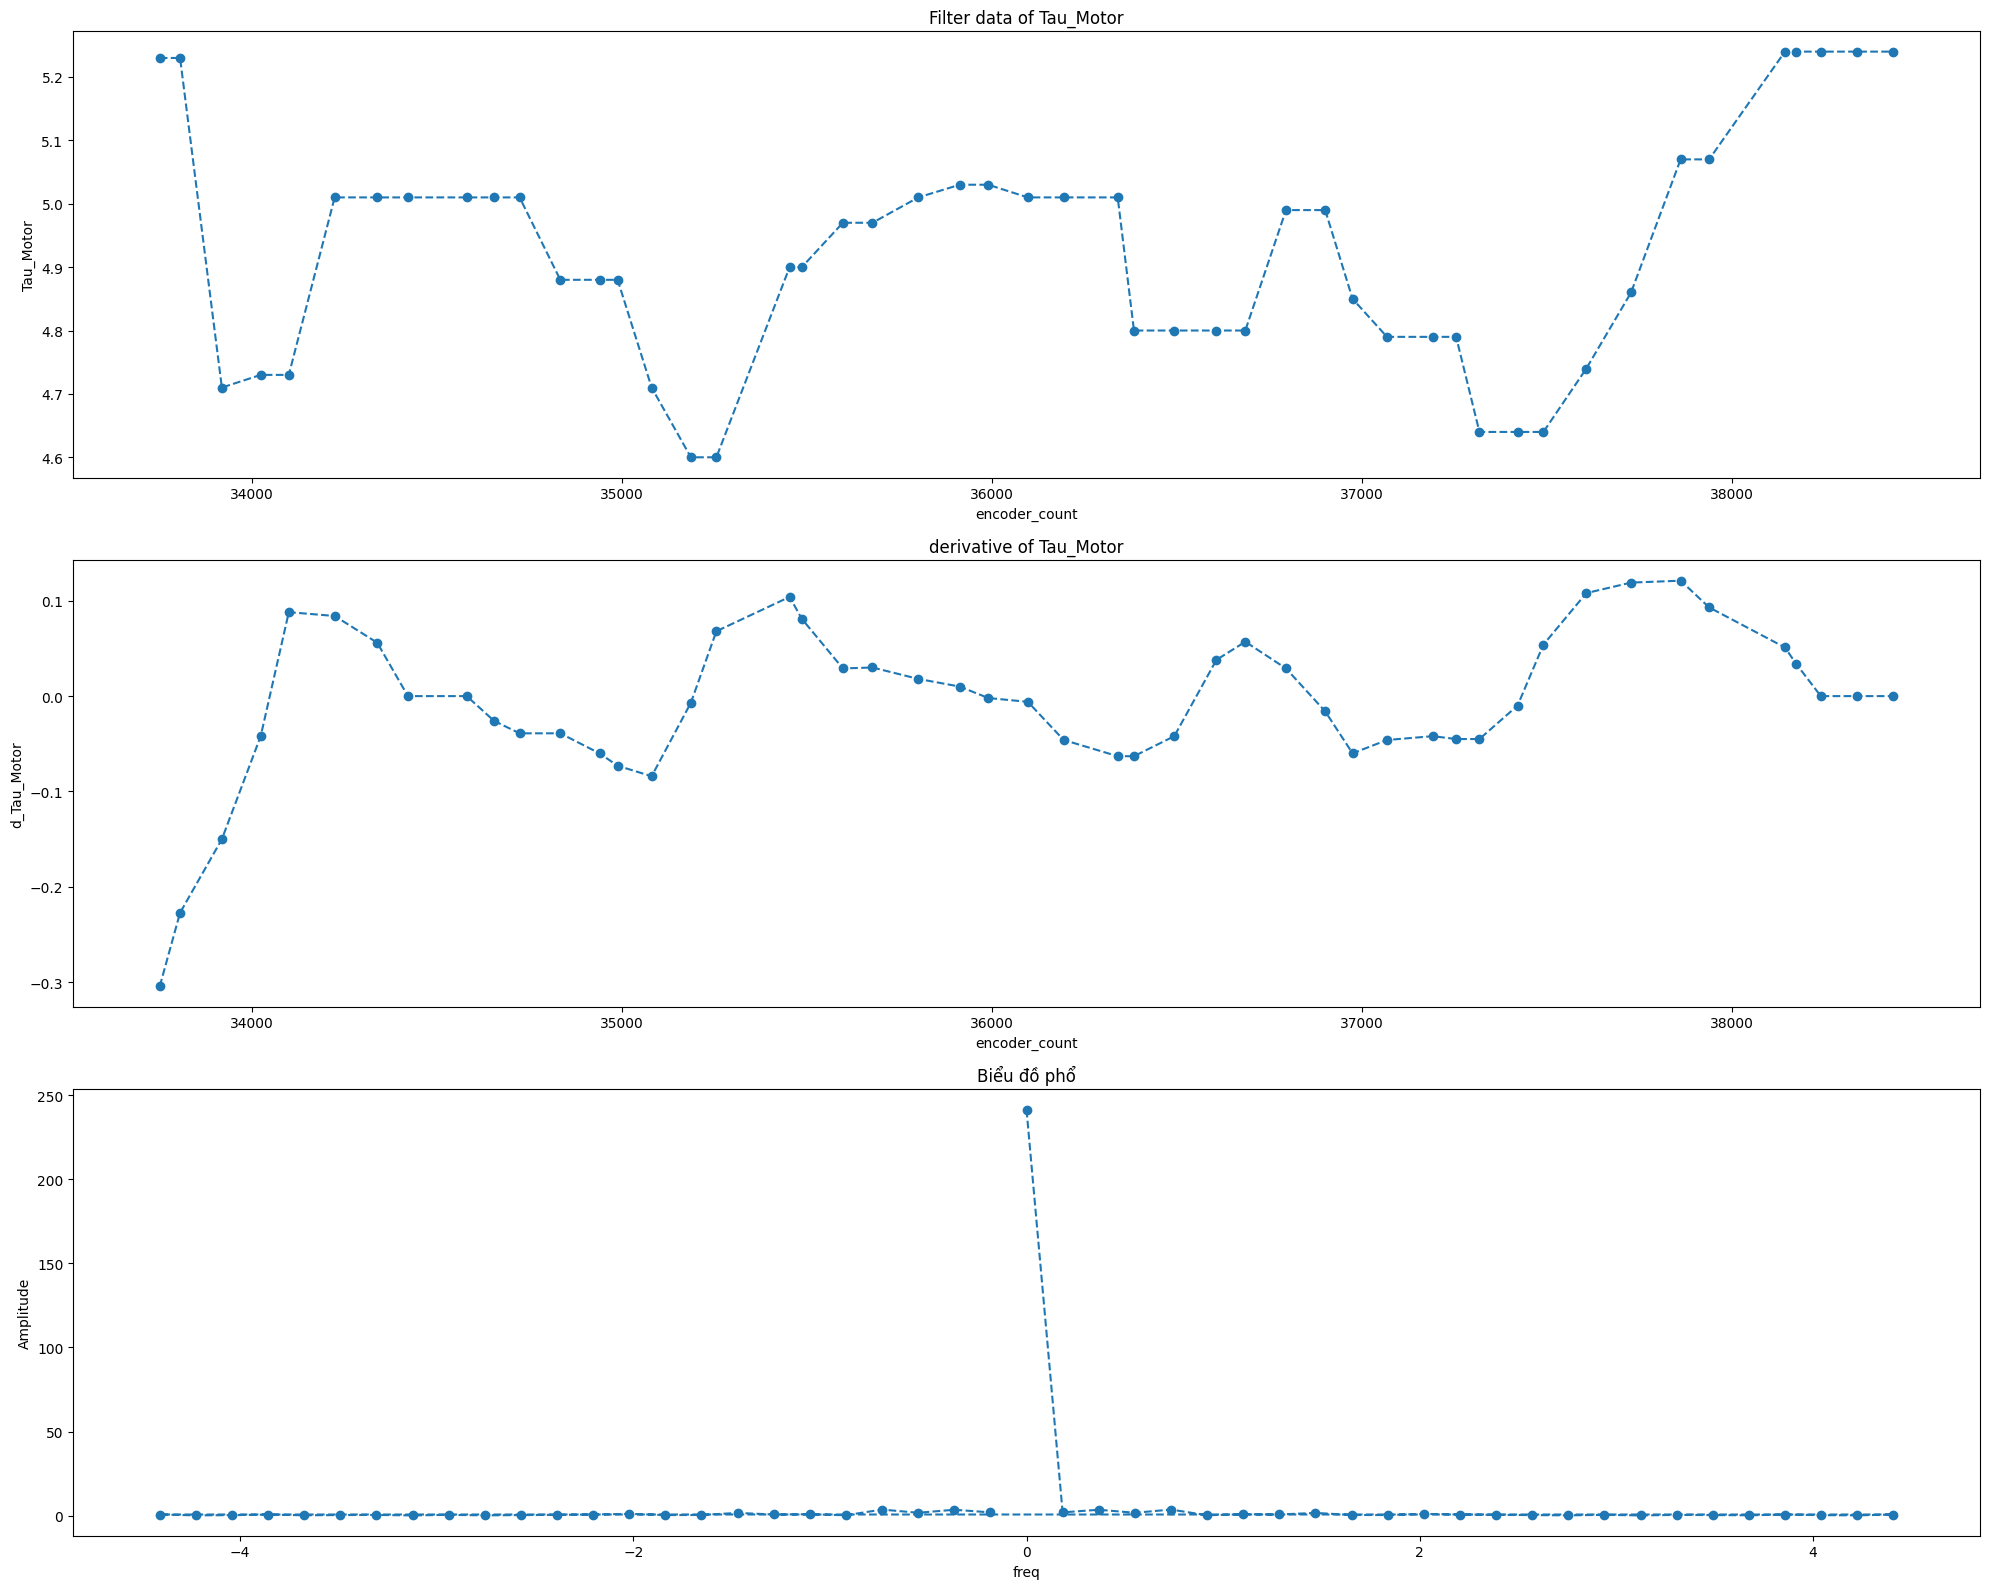

In [ ]:
from scipy.fft import fft, fftfreq, ifft
from scipy.signal import savgol_filter

sampling_rate = int(len(view_data['t'])/(max(view_data['t'])-min(view_data['t'])))
print("Sampling rate:", sampling_rate)
print("Sample: ", len(view_data['t']))
print("Encoder circle: ", max(view_data['encoder_count'])-min(view_data['encoder_count']))
columns_to_plot = ['Tau_Motor', 'Tau_1', 'vel', 'Tau_2']
view_col = columns_to_plot[0]

filtered_data = moving_average(view_data[view_col], 1)

# Fourier transform
fft_result = fft(filtered_data)
freqs = fftfreq(len(filtered_data), 1/sampling_rate)

# Max frequency
idx = np.argmax(np.abs(fft_result))
freq = freqs[idx]
list_freq = extract_peaks(freqs, fft_result, 20)
print("Max freq:", freq)
print("list pick freqs:", list_freq)
# Derivaive
if view_col == 'vel':
    derivative = savgol_filter(filtered_data, window_length=3, polyorder=2, deriv=1)
elif (view_col == 'Tau_1') or (view_col == 'Tau_2'):
    derivative = savgol_filter(filtered_data, window_length=5, polyorder=3, deriv=1)
else:
    derivative = savgol_filter(filtered_data, window_length=5, polyorder=2, deriv=1)

# Vẽ biểu đồ
plt.figure(figsize=(20, 16))

plt.subplot(3, 1, 1)
plt.plot(view_data['encoder_count'], filtered_data, marker='o', linestyle='--')
plt.title('Filter data of {}'.format(view_col))
plt.xlabel('encoder_count')
plt.ylabel(view_col)

plt.subplot(3, 1, 2)
plt.plot(view_data['encoder_count'], derivative, marker='o', linestyle='--')
plt.title('derivative of {}'.format(view_col))
plt.xlabel('encoder_count')
plt.ylabel('d_{}'.format(view_col))

plt.subplot(3, 1, 3)
plt.plot(freqs, np.abs(fft_result),marker='o', linestyle='--')
plt.title('Biểu đồ phổ')
plt.xlabel('freq')
plt.ylabel('Amplitude')

plt.tight_layout()
# plt.savefig(work_dir/'figures/turn {}/{}_feature.png'.format(turn, view_col), format='png', dpi=300) # must save before show()
plt.show()

Chốt chọn các bộ lọc cho từng bộ data

## Thử lọc fft low pass

Threshold:  1


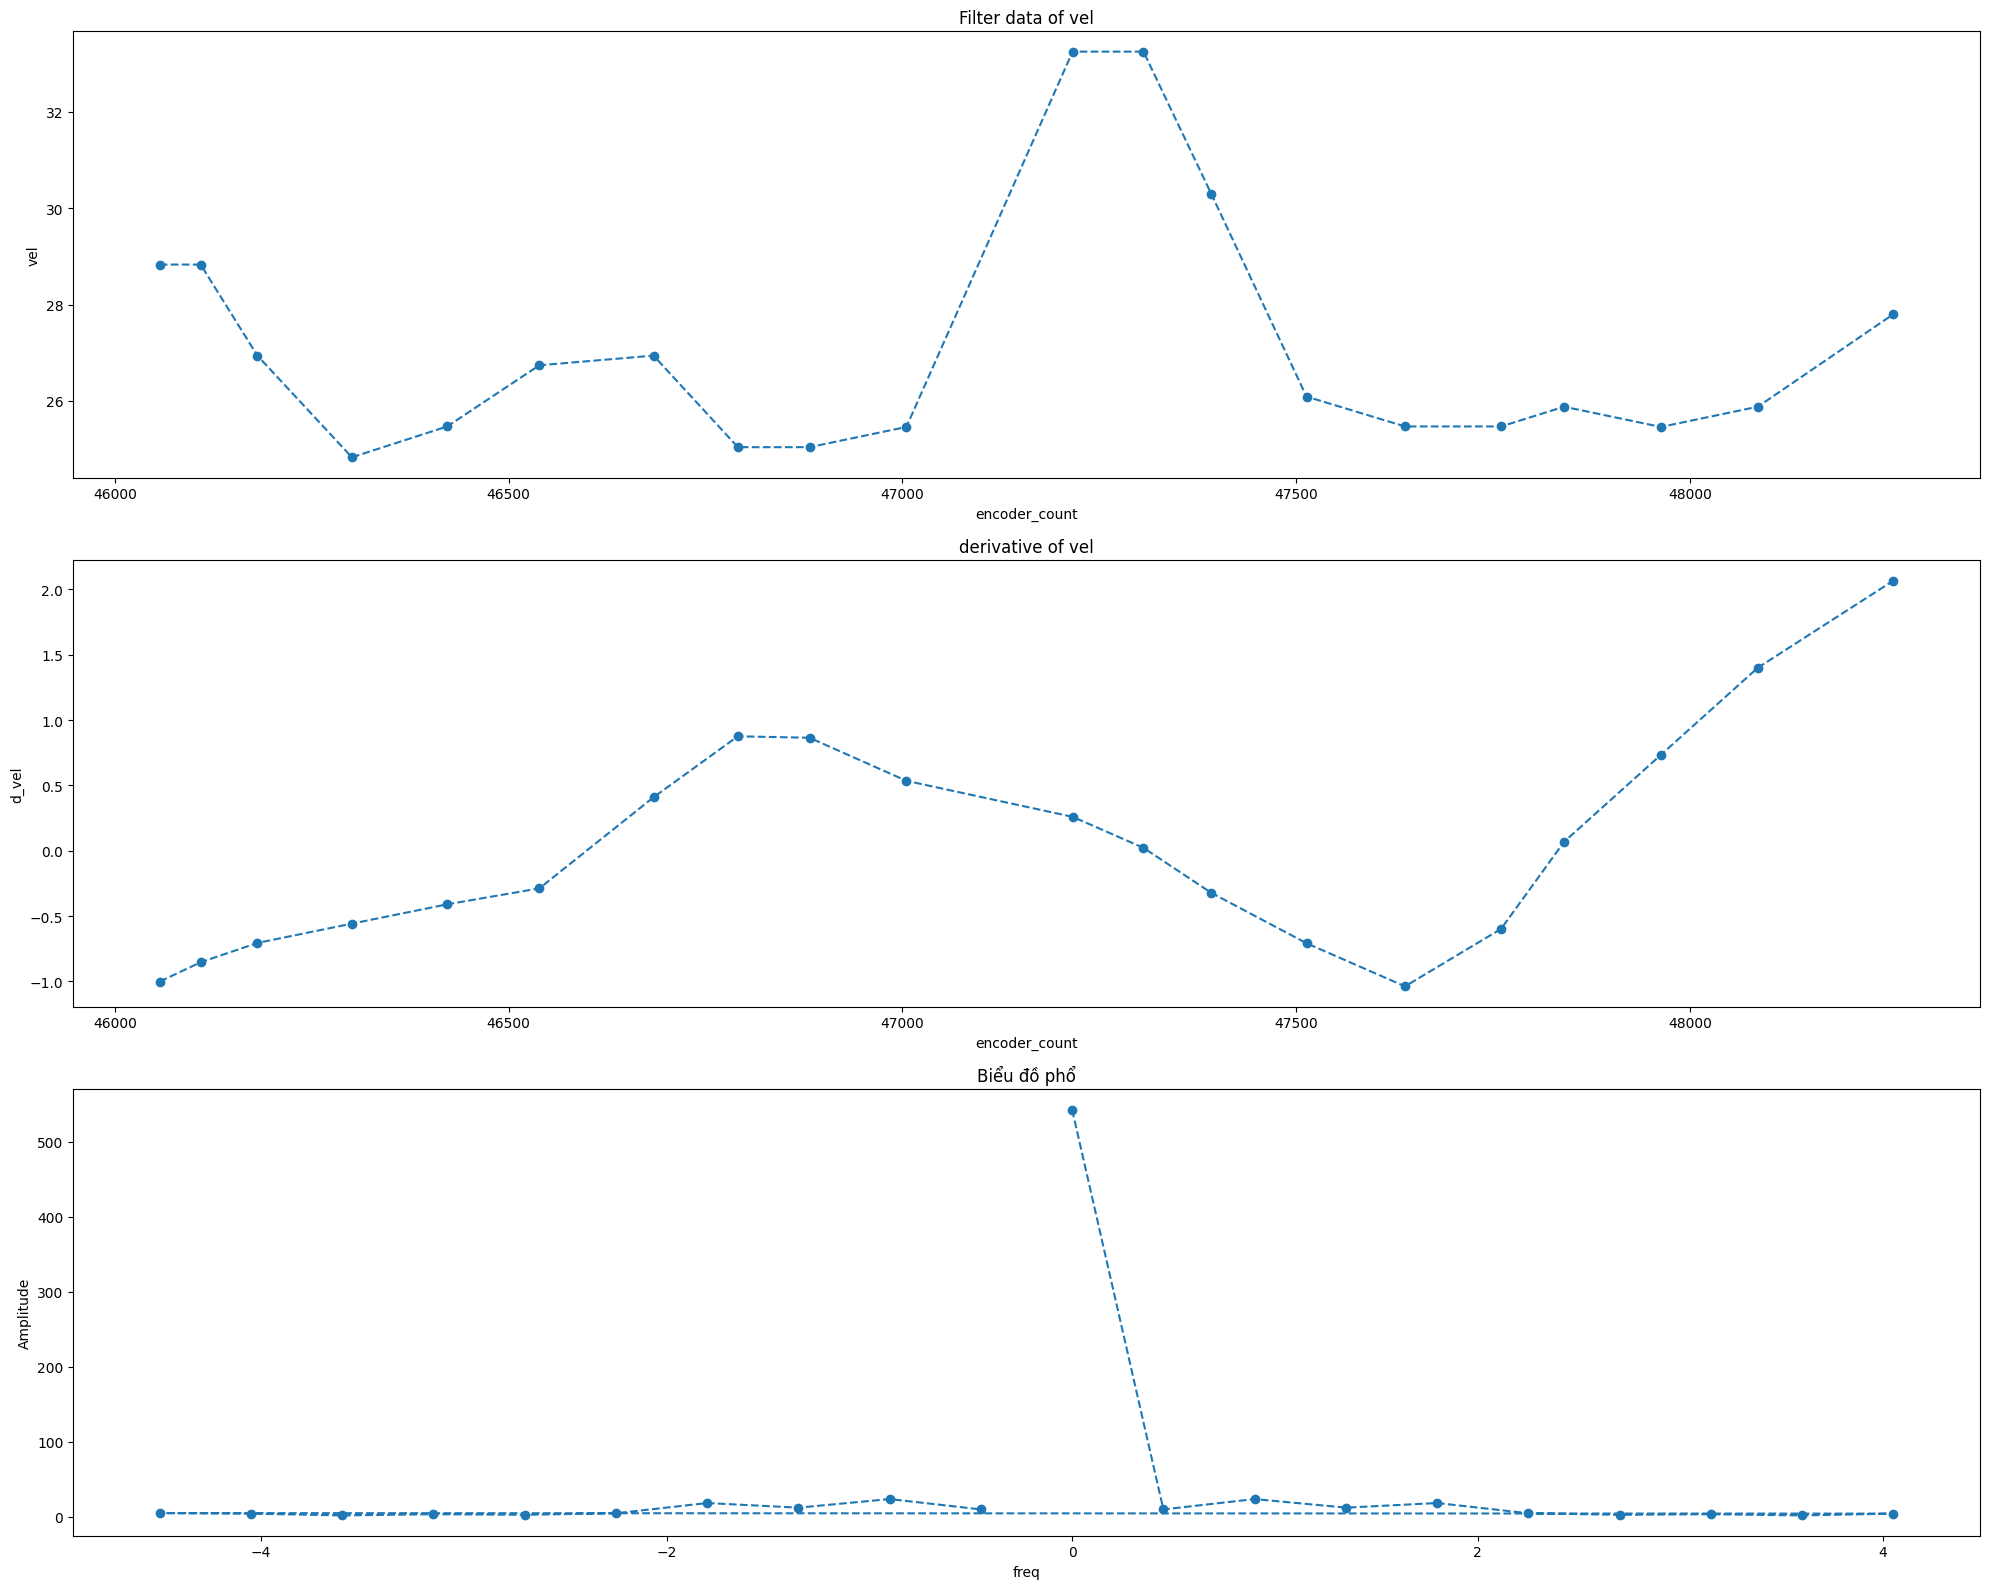

Threshold:  2


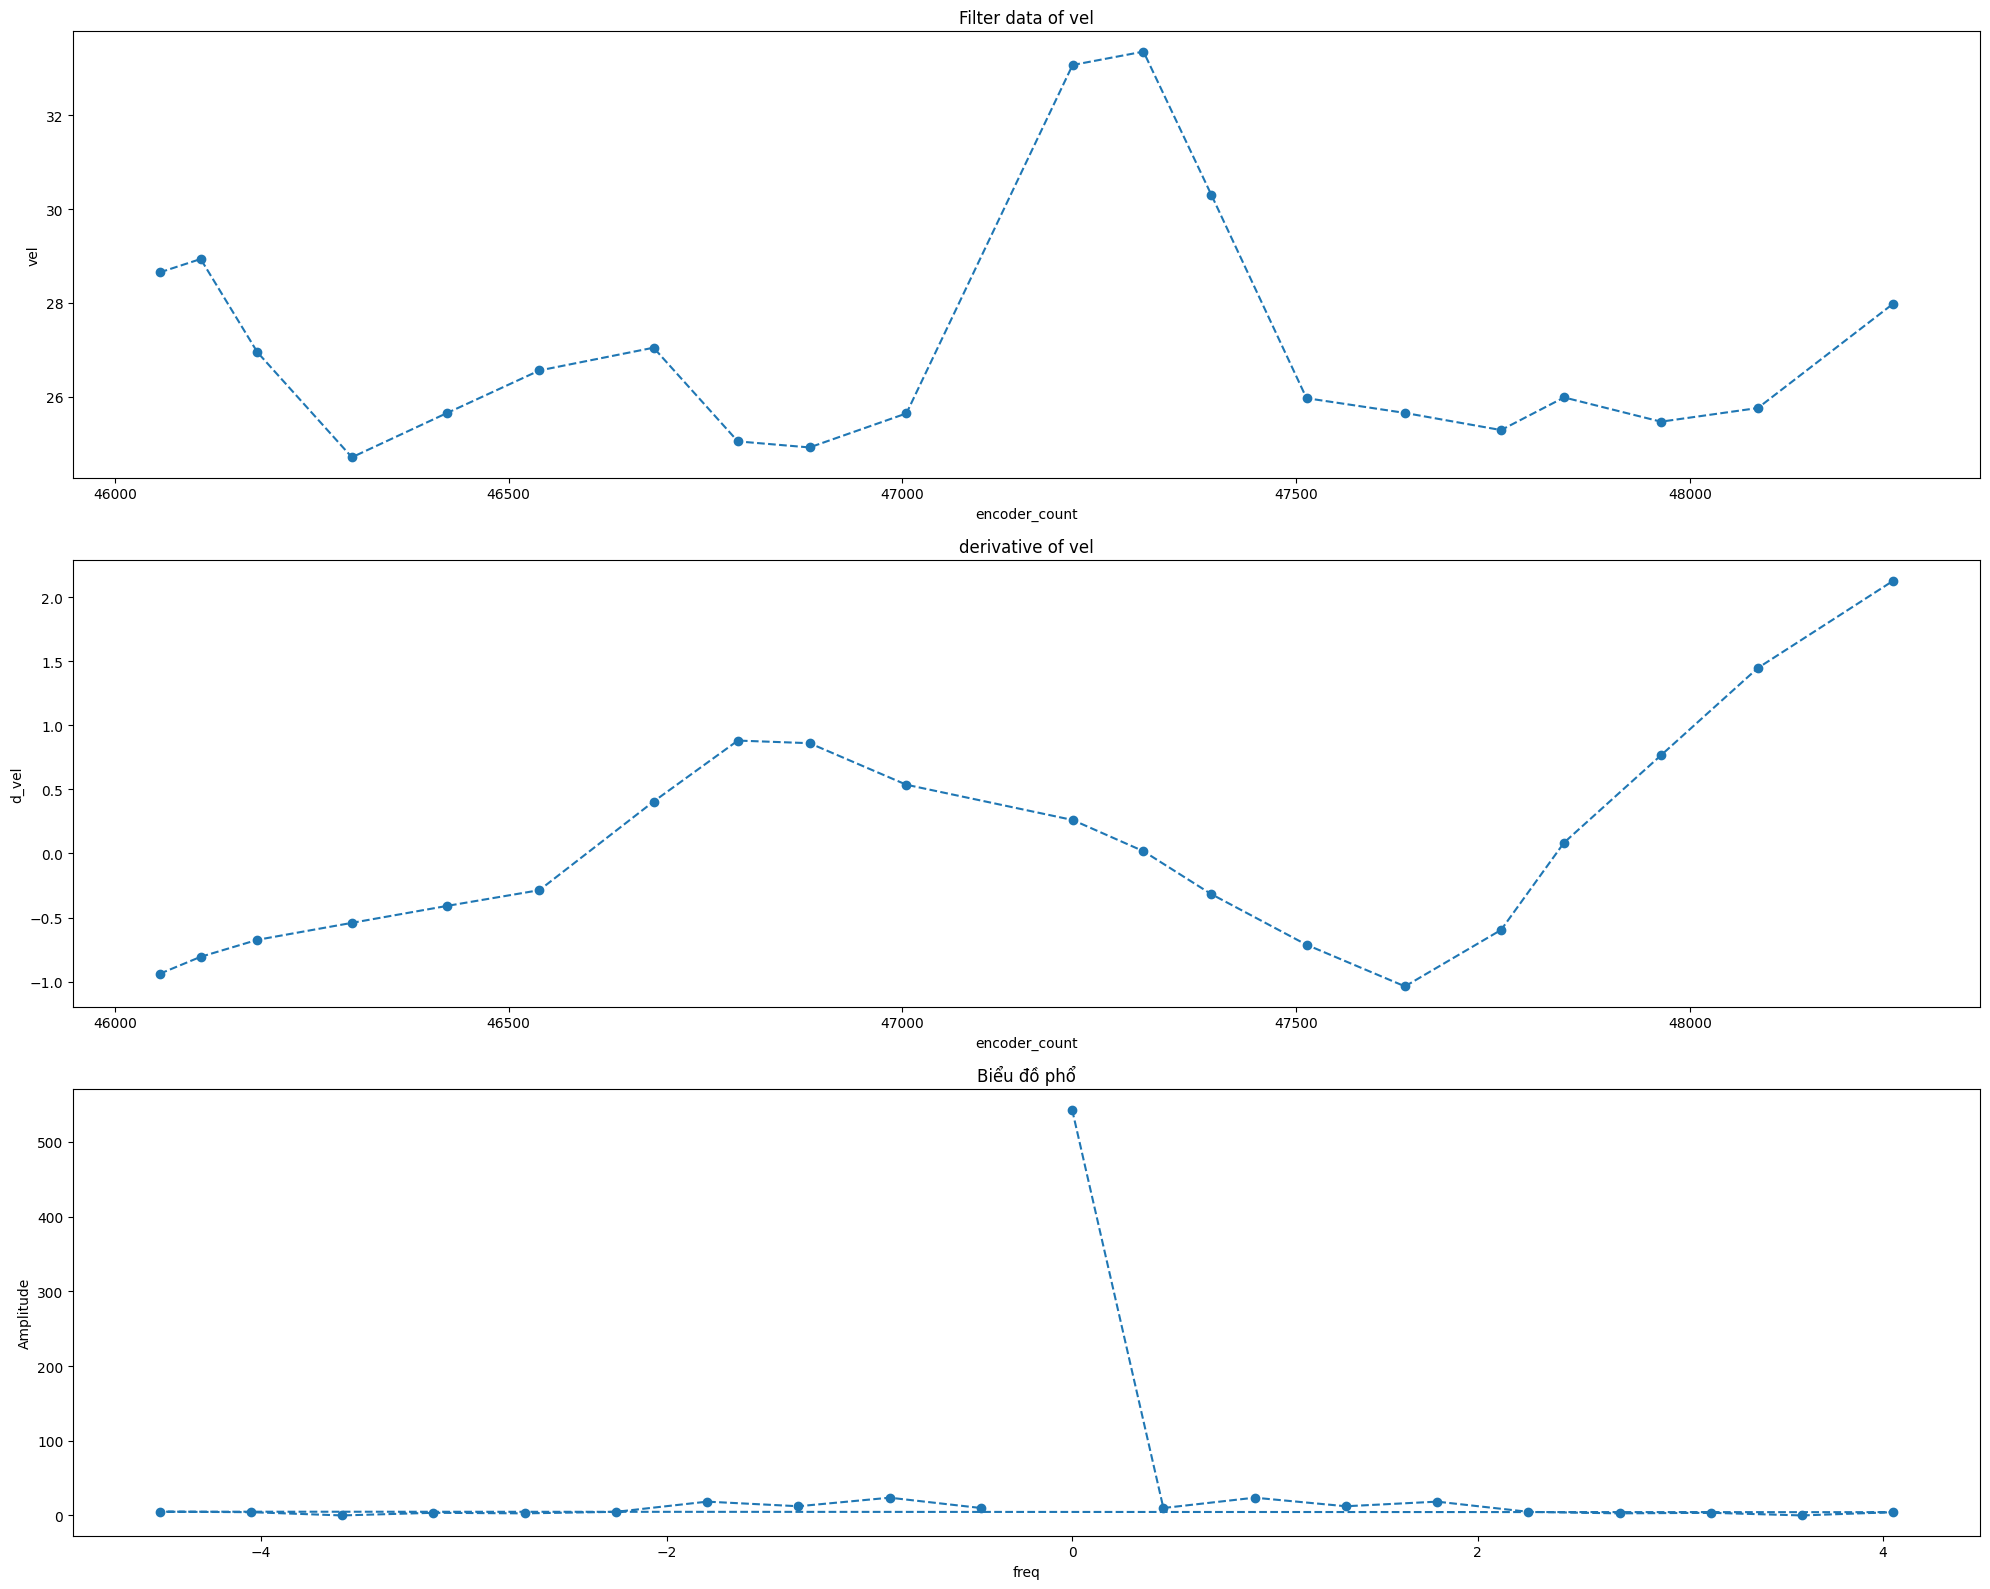

Threshold:  3


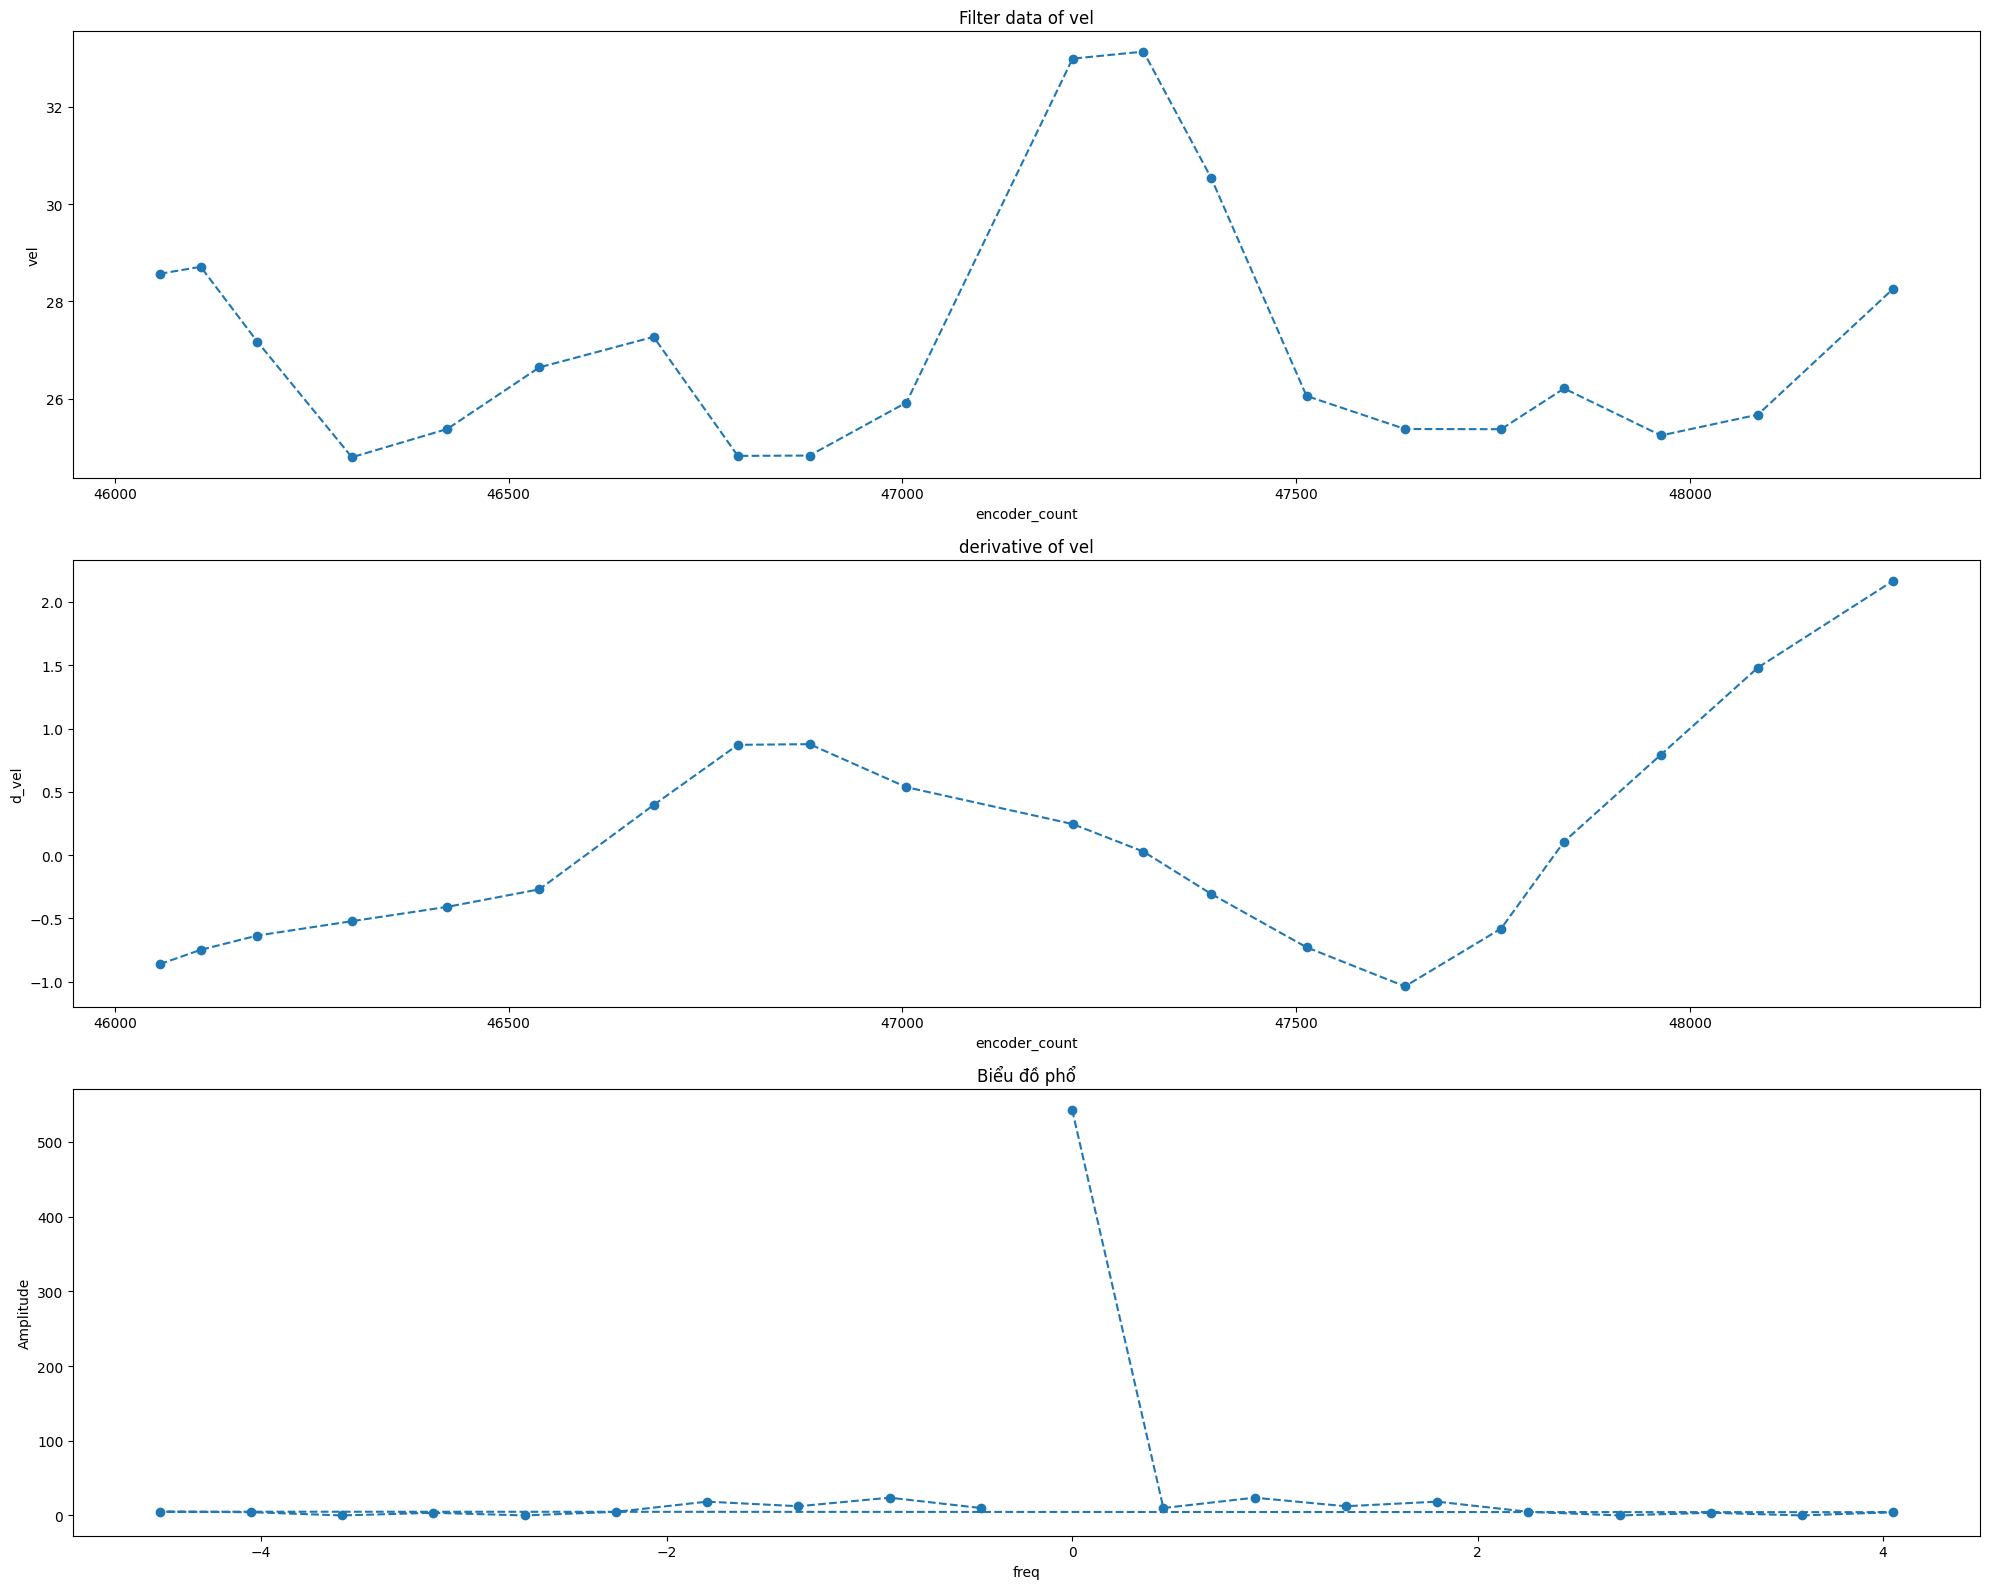

Threshold:  5


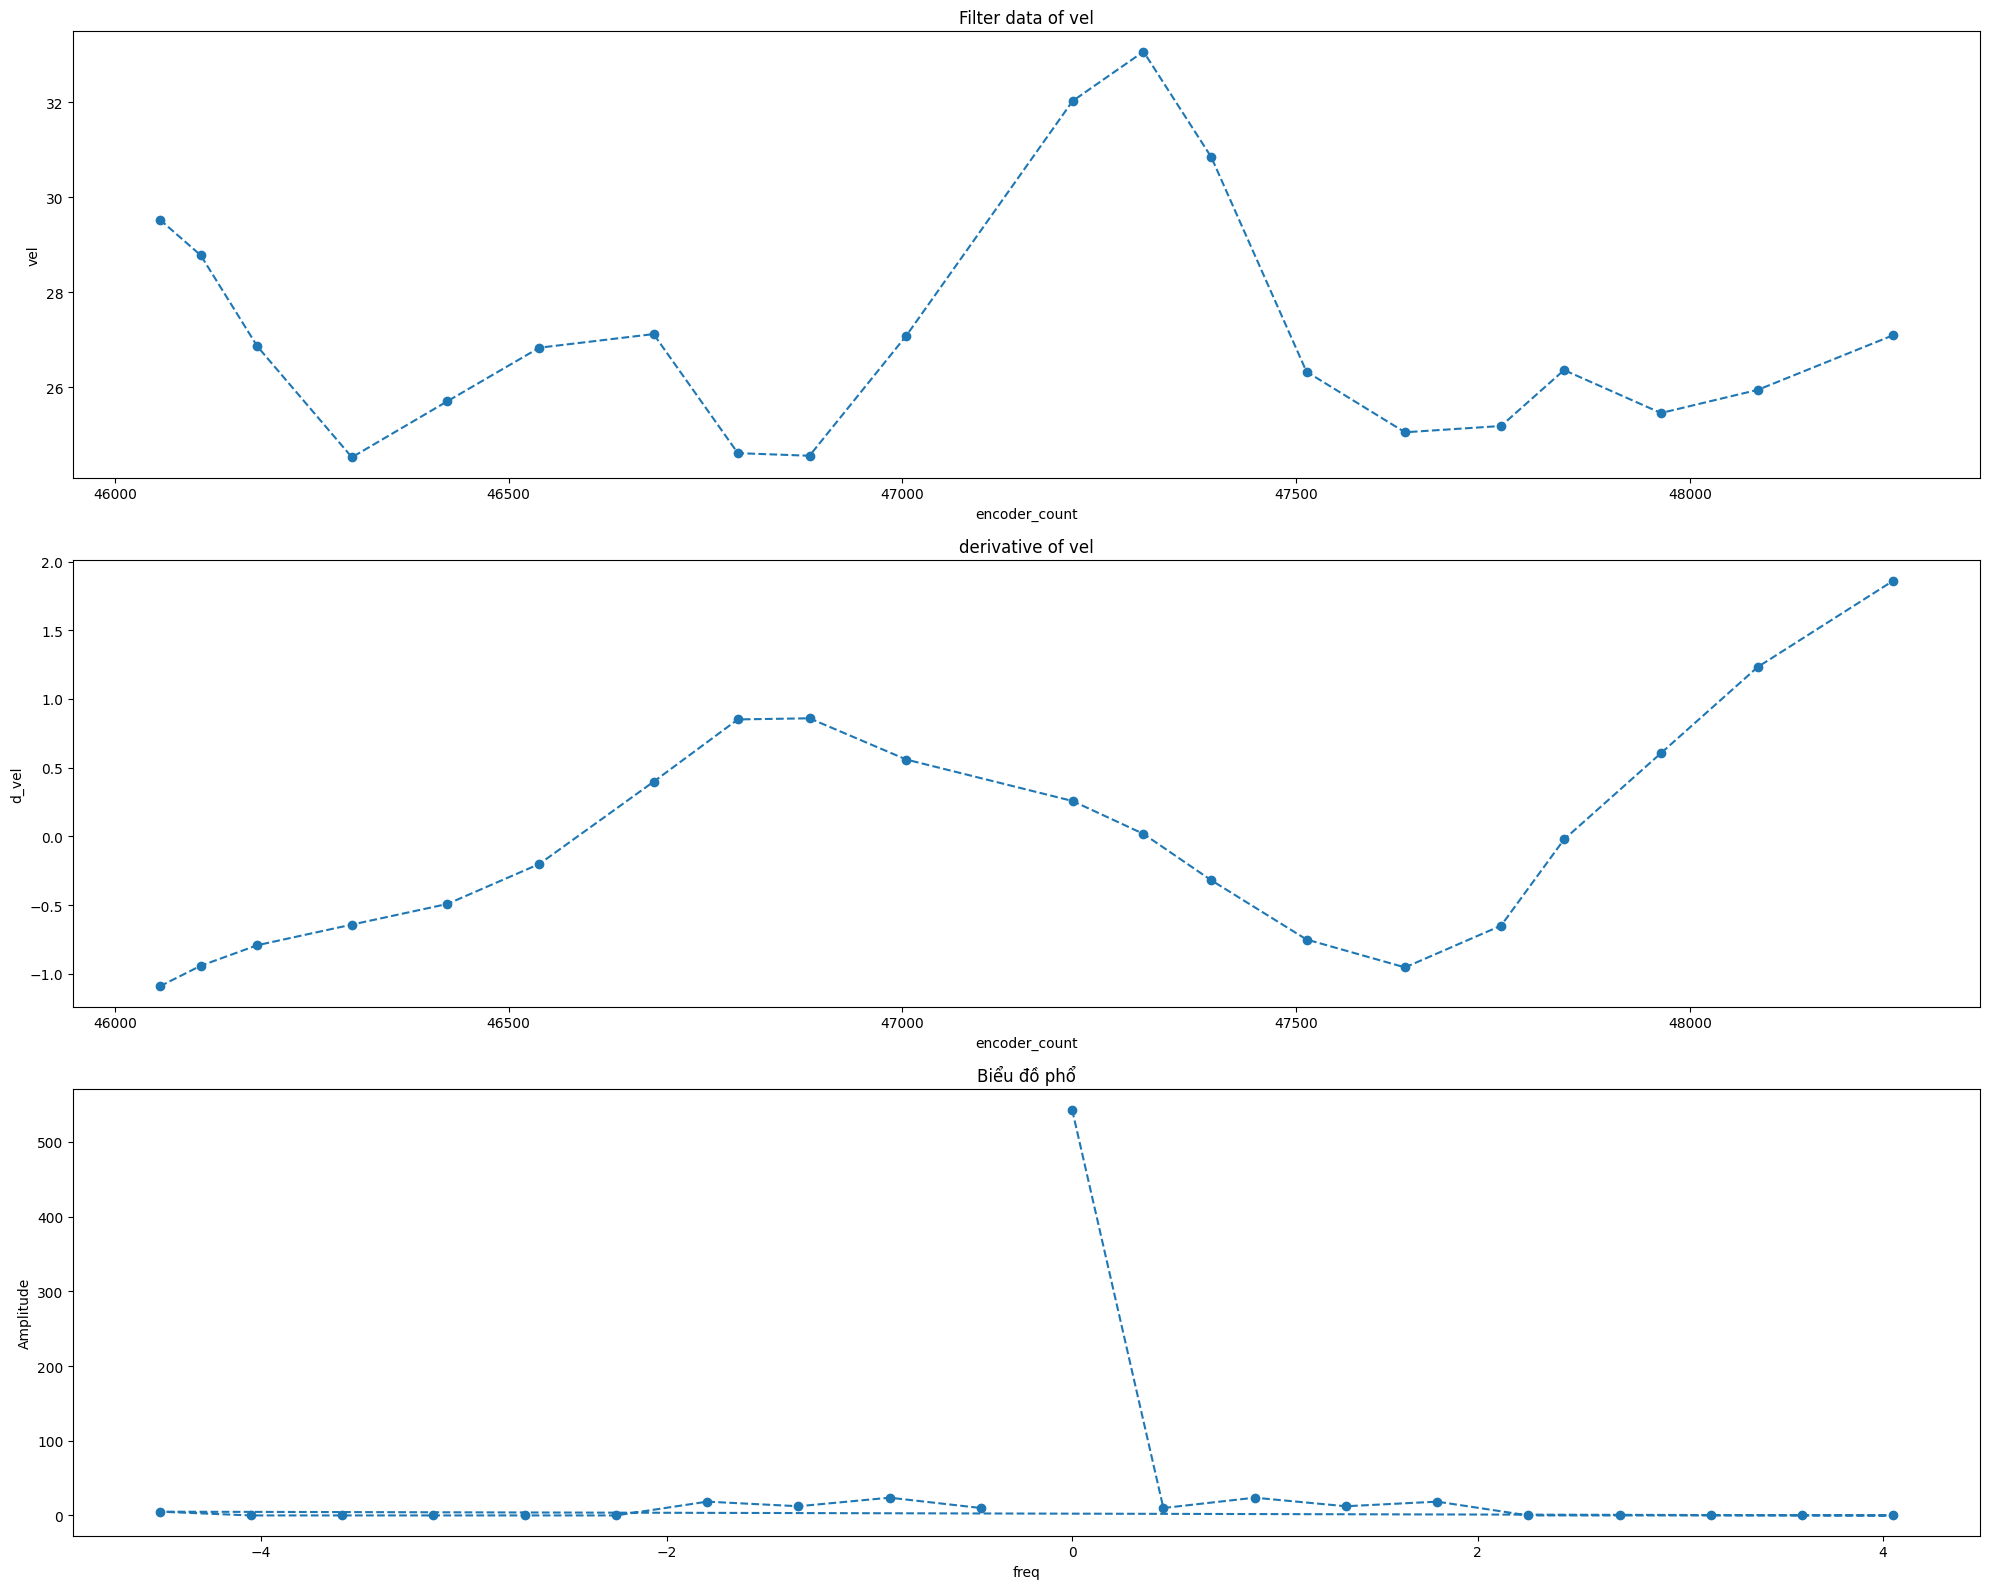

Threshold:  10


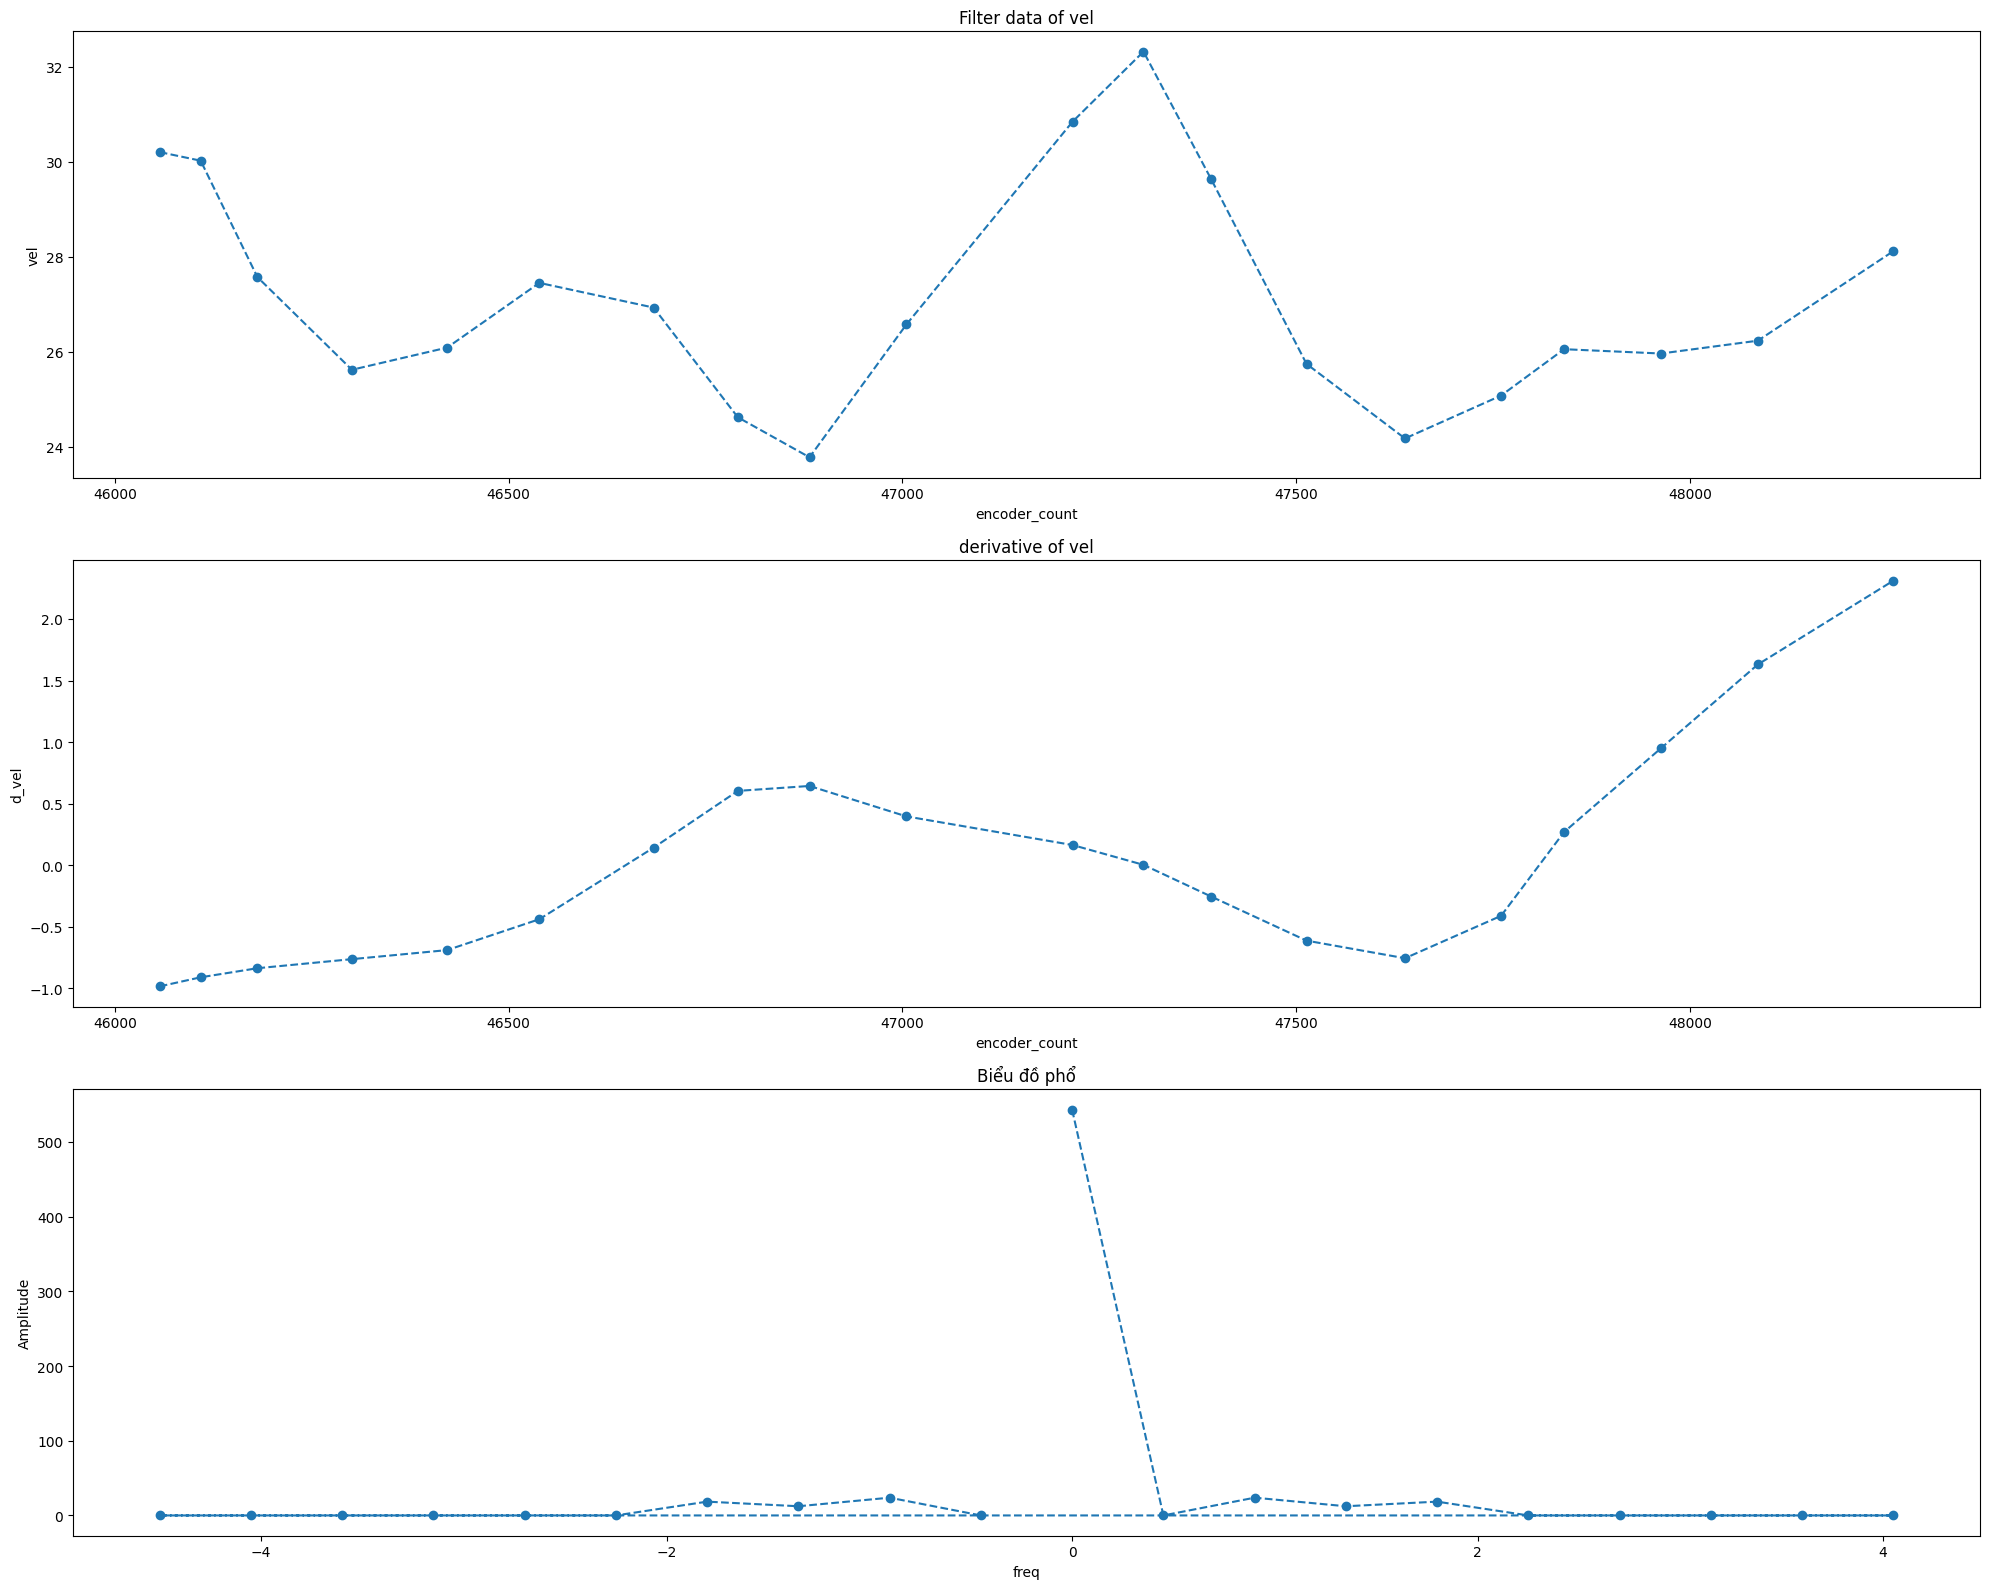

Threshold:  50


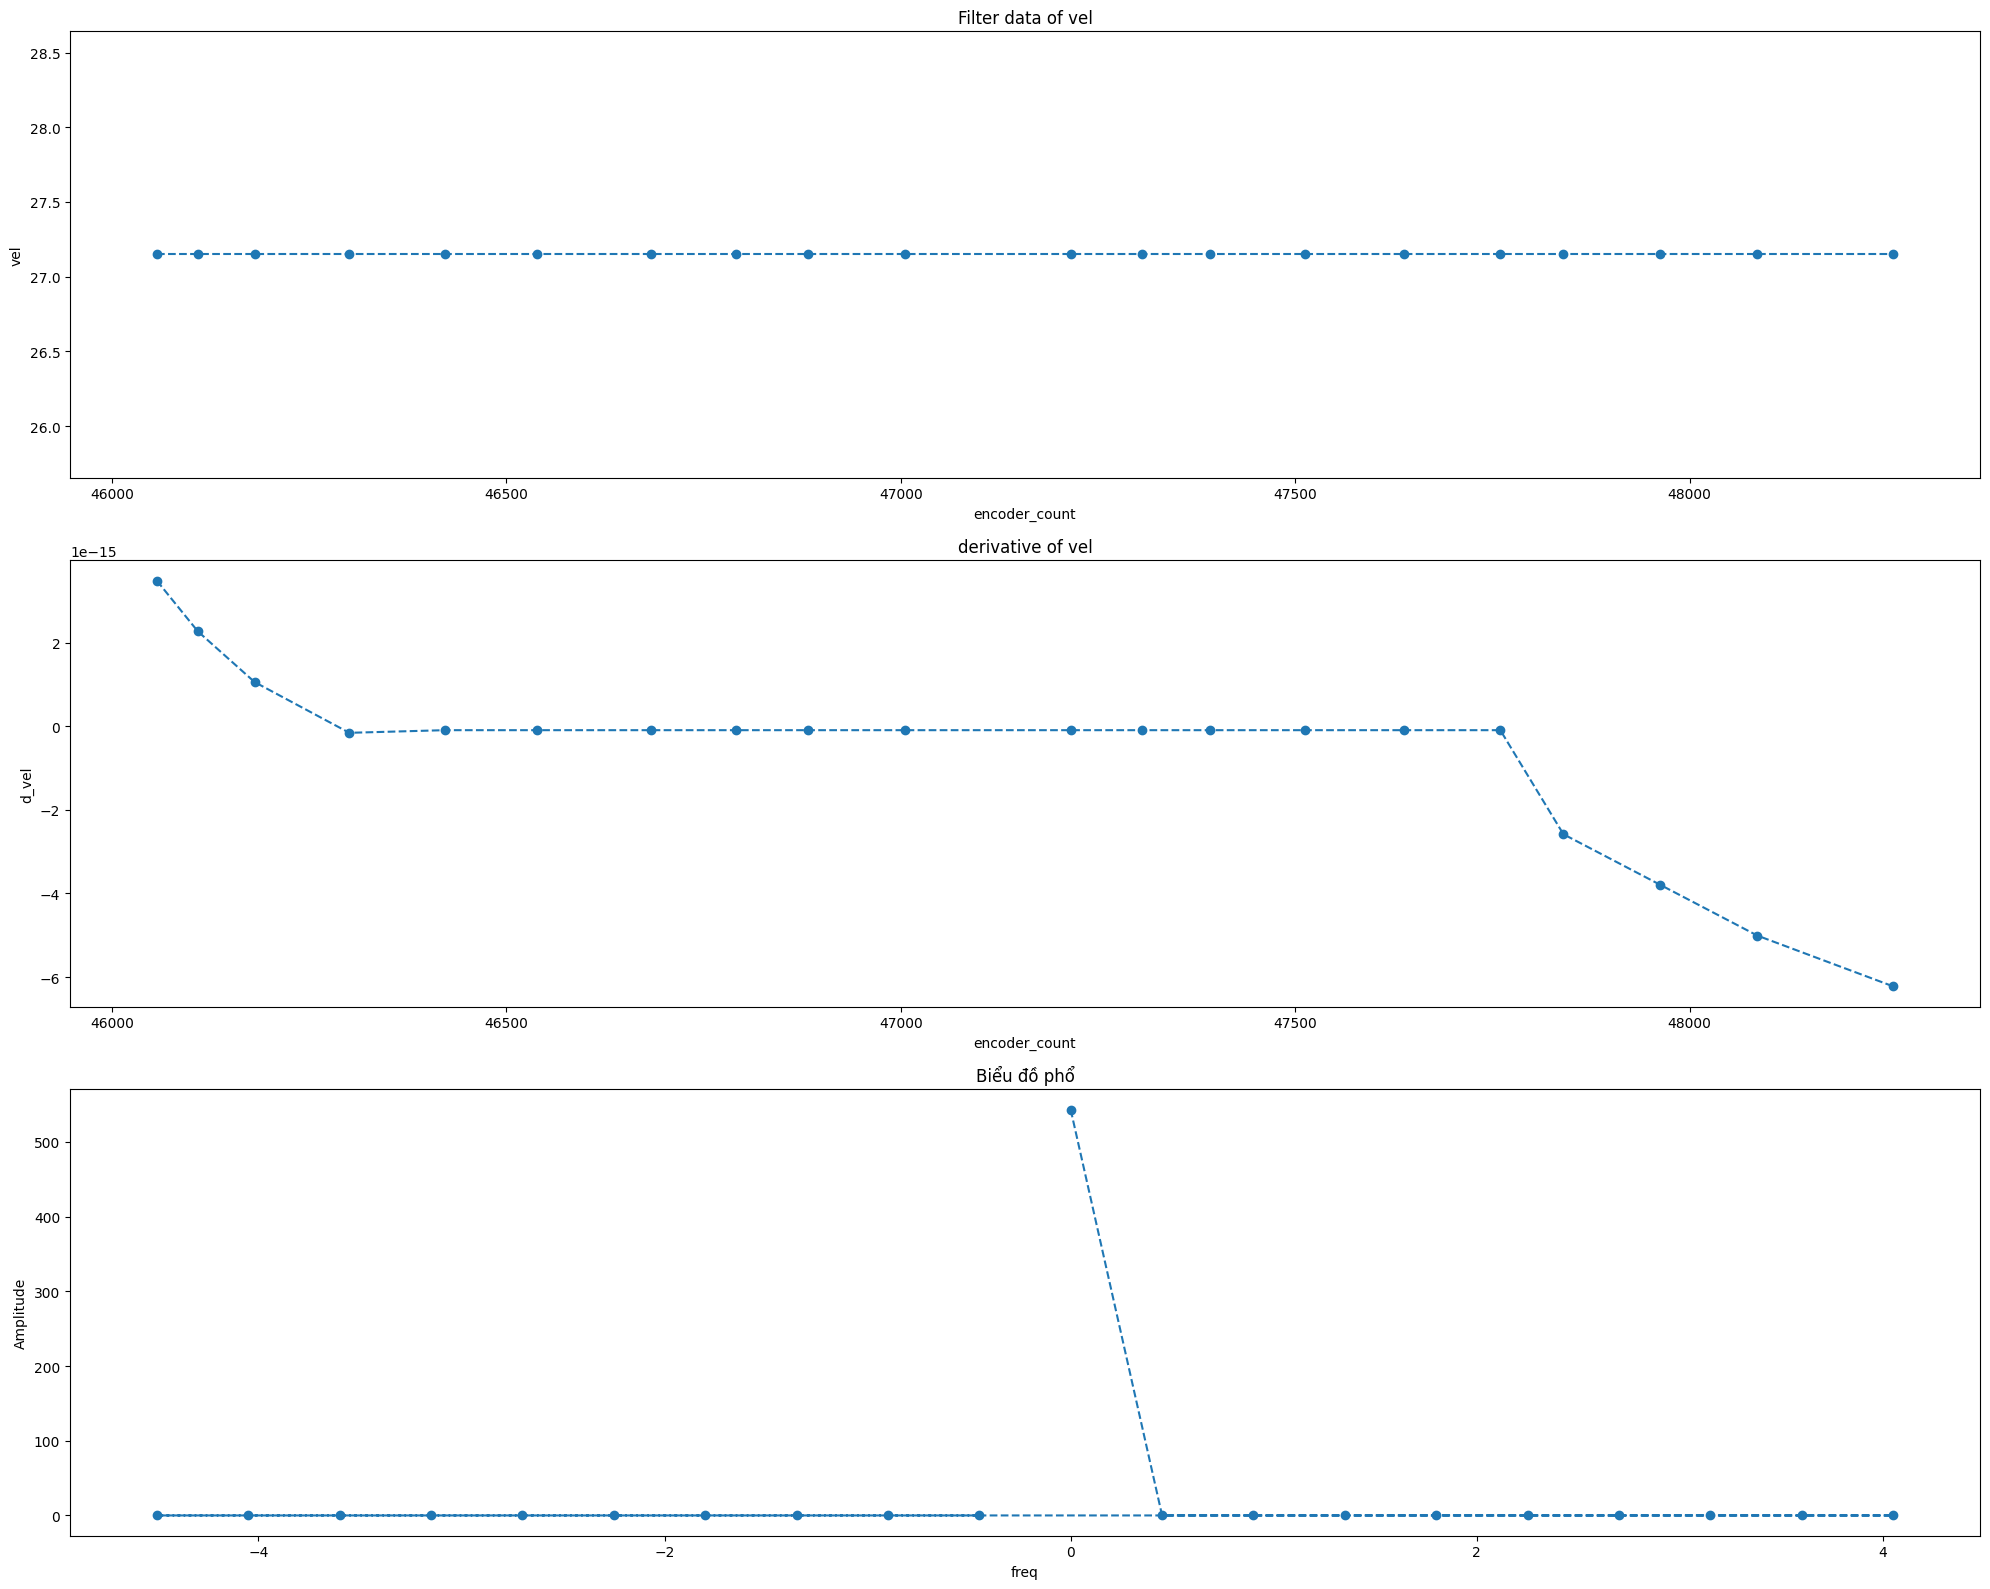

In [ ]:
l_threshold = [1,2,3,5,10,50]
# l_threshold = [5,100,200]
for threshold in l_threshold:
    print("Threshold: ", threshold)
    filtered_data = remove_low_amplitude_components(moving_average(view_data[view_col], 1), sampling_rate, threshold)

    # Fourier transform
    fft_result = fft(filtered_data)
    freqs = fftfreq(len(filtered_data), 1/sampling_rate)

    # Max frequency
    idx = np.argmax(np.abs(fft_result))
    freq = freqs[idx]

    # Derivaive
    derivative = savgol_filter(filtered_data, window_length=9, polyorder=2, deriv=1)

    # Vẽ biểu đồ
    plt.figure(figsize=(20, 16))

    plt.subplot(3, 1, 1)
    plt.plot(view_data['encoder_count'], filtered_data, marker='o', linestyle='--')
    plt.title('Filter data of {}'.format(view_col))
    plt.xlabel('encoder_count')
    plt.ylabel(view_col)

    plt.subplot(3, 1, 2)
    plt.plot(view_data['encoder_count'], derivative, marker='o', linestyle='--')
    plt.title('derivative of {}'.format(view_col))
    plt.xlabel('encoder_count')
    plt.ylabel('d_{}'.format(view_col))

    plt.subplot(3, 1, 3)
    plt.plot(freqs, np.abs(fft_result),marker='o', linestyle='--')
    plt.title('Biểu đồ phổ')
    plt.xlabel('freq')
    plt.ylabel('Amplitude')

    plt.tight_layout()
    # plt.savefig(work_dir/'figures/turn {}/{} feature/fft_filter_threshold_{}.png'.format(turn, view_col, threshold), format='png', dpi=300) # must save before show()
    plt.show()